# Anomaly detection in multiclass label classification
#### Authors:
### Maria Musiał 156062
### Martyna Stasiak 156071
------------------------------------

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction (showing which part of which series is responsible for a defect)
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Masking, Lambda, Conv1D, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score

## Generating the data

In [3]:
np.random.seed(42)

In [4]:
n = 50000

In [5]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0: #blue has an outlier
        base[np.random.randint(0,n), 0] += 2 
    if classes[1] > 0: #orange has an outlier (dip)
        base[np.random.randint(0,n), 1] -= 2 
    if classes[2] > 0: #green has outlier for length 4
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0: #orange has a len 8 spike 
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0: #blue-green tradeoff
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [6]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


[False False False False  True]


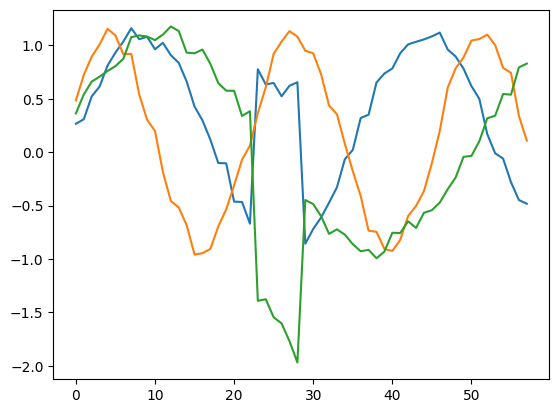

[False False False  True  True]


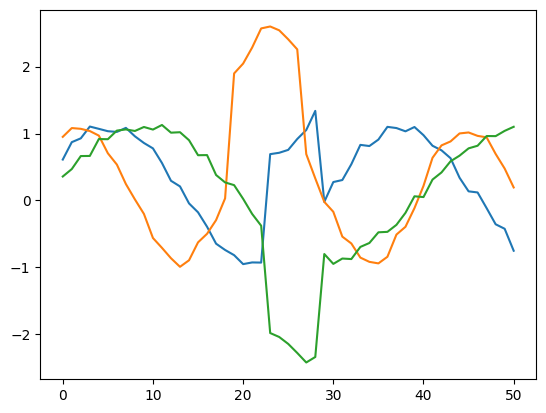

[False False False False False]


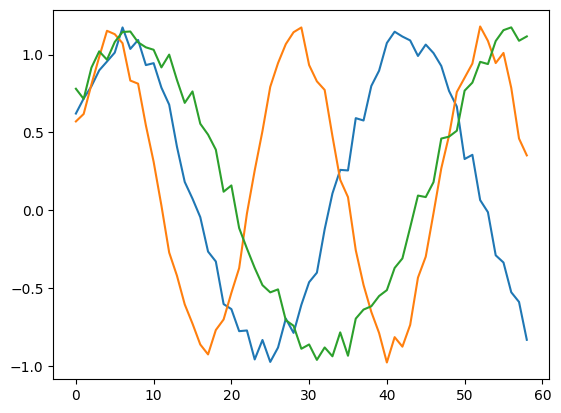

[ True False False False  True]


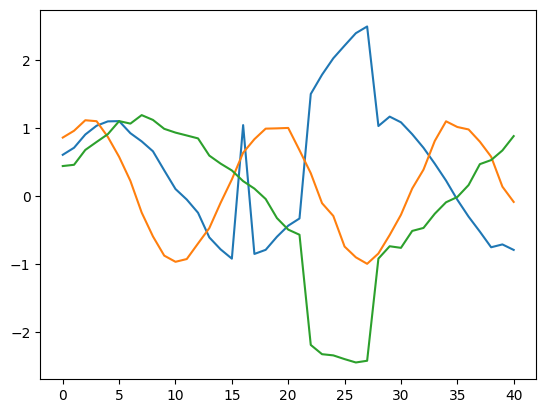

[False  True False False False]


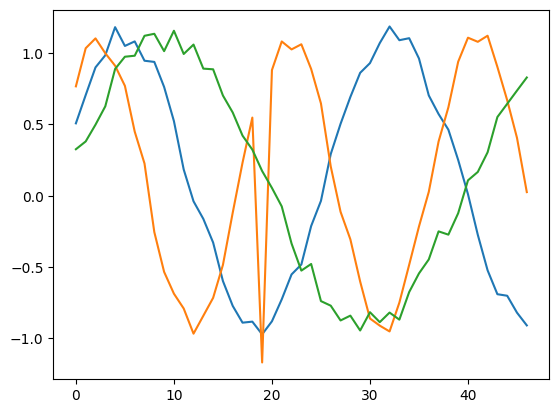

In [54]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

---------------------------------------------
## This problem is a multiclass label classification.  
Each instance can belong to multiple classes at once, which translates to the fact that each candy can have zero up to multiple defects.<br>
We apply <b>Long Short Term Memory</b> network, as its best suited in this case. <br>
The data provided is fairly easy for network to learn. The outliers we want to detect are distinct most of the time. <br>
### Preprocessing:
1. The outputs (defects) are converted to <b>multi-hot encoded labels</b> with values 0 or 1 for better processing and computing.<br>
2. The data is <b>padded</b>, as we have different lenghts sequences. Each sequence is padded with 0 at the end to length of the longest sequence in the dataset. This will later on be answered with Masking layer in architecture, so that network doesnt mistakenly learn anything based on padded parts.<br>
3. Next step is applying <b>MinMax Scaler</b> in range 0-1 for data to be normalized. This ensures that network learns more easily the dependencies.<br>
4. We <b>split data</b> 80-20 train-test. Additionally, we extract validation data from 25% of train dataset. In the end we end up with 60-20-20 train-validation-test.<br>
5. We use <b>He Normal initializer</b>, which provides initial weights for network. It lets us work better with layers that use ReLU activation functions, as we will use in our LSTM layers. This improves convergence. With default initialization our network didn't learn until 20th epoch. With it, it starts to converge almost instantly.


We also checked the distribtion of classes, as this could negatively impact learning if they were imbalanced. Fortunately, the classes are balanced, each having around 12k occurences. Hence, preprocessing does not require dealing with that and network will learn each class as aproximately same rate.

### Architecture:
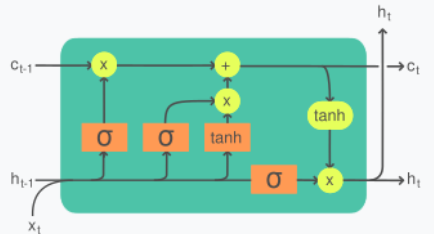
1. <b>Masking layer</b> - To not let network learn on padded parts of sequences, in input tensor, we  mask parts of sequences. Data provided to downstraem layers won't have 0's.
2. <br>LSTM</b> (64 units)- Here we initialize weights with chosen, He Normal initializer. We use LSTM, as it's recurrent network, that preserves information from previos units. This lets us treat the data, as sequence with cause-effect relationship. Without it we wouldn't be able to precieve trends, as for example data rising over time. Then, we wouldn't be able to predict anomalies, as some of the outputs-anomalies are effect of 2 series having anomalies at once. 
3. <b>Dense</b> (5 units)- 5 units, as we have 5 possible outputs (anomalies) for the series. We choose sigmoid activation, to work with each anomally independently. <br>
> In summary, we have 17.7k trainable parameters. Input is (x, 3) and output (5), where x is the maximal length of sequences.

As <b>optimizer</b> we choose Adam optimizer, as it implements adaptive learning rates and bias  correction. This leads to faster convergence. <br>
As loss function and a metric we choose binary crossentropy. <br>
> BCE=− N1 ∑ i=1N [y i log(p i )+(1−y i)log(1−p i )]

This loss function is designed for multilabel classification, as it measures performance of model that is designed to predict 2 possible outcomes (probabilities 0 or 1 in our case) and its outcome is probability value between them. <br> We treat predictions separately for each anomaly. 

For <b>training</b> we use 120 epochs, as around this number our model convenges. Batch size is 32. This provides good trade-off between efficiency and accuracy. <br>
We also use Early Stopping with patience of 15 and restoration of best weights as callback. If our model does not improve for 15 epochs, the training is stopped and the best performing weights restored.

----------------------------

In [8]:
# Convert to multi-hot encoded labels
num_classes = len(yl[0])

def true_false_to_multi_hot(labels, num_classes):
    encoded_labels = []
    for label in labels:
        multi_hot_label = [1 if x else 0 for x in label]
        encoded_labels.append(multi_hot_label)
    return np.array(encoded_labels)


multi_hot_labels = true_false_to_multi_hot(yl, num_classes)
# print(multi_hot_labels)

## Checking class distribution 
<span style="font-size: 20px;">to get to know if we need some class weights to help model learn by providing more equal distribution. As it turns out, the classes are distributed equally, so there is no class imbalance. Meaning that no calculation of class weights is needed, as model should already be learning classes at approximately the same rate.</span>

In [9]:
# getting to know class weights cause of minority labels ??
class_distribution = np.sum(multi_hot_labels, axis=0)
print(f"class distrib: {class_distribution}")


class distrib: [12584 12390 12537 12652 12542]


In [11]:
# Padding because of varying sequence lengths
sequence_lengths = [len(seq) for seq in xl]
max_len = max(sequence_lengths)
padded_sequences = pad_sequences(xl, maxlen=max_len, padding='post', dtype='float32')  #post means that the padding is added after the sequence

In [12]:
#Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
padded_sequences = scaler.fit_transform(padded_sequences.reshape(-1, 3)).reshape(-1, padded_sequences.shape[1], 3)

In [13]:
#split data 80-20
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, multi_hot_labels, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2 of the total dataset
)

## He Normal initializer 
<span style="font-size: 22px;">draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2/fan_in), where fan_in is the number of input units in the weight tensor.
<br>It is the best initializer in case of using ReLU as activation functions, as we do in our architecture. 
<br> this initialization improves convergence. Without it, first 20 epochs our model didn't learn.

In [10]:
from keras.initializers import HeNormal

initializer = HeNormal()

In [14]:
# Define the model with a Masking layer to not train on the padded parts. 
model = Sequential([
    Masking(mask_value=0, input_shape=(max_len, 3)),
    LSTM(64, kernel_initializer = initializer),
    # LSTM(32),
    Dense(5, activation='sigmoid')  # Multi-label classification for 5 potential anomalies
])

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 59, 3)             0         
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 17733 (69.27 KB)
Trainable params: 17733 (69.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy',  # Use categorical crossentropy for multi-label classification
              metrics=['binary_crossentropy'])  # Hamming Loss, Subset Accuracy dont work #mse #binary accuracy 


#Early stopping
callbacks = EarlyStopping(monitor="loss", patience=15, restore_best_weights= True)

# Fiting the model
history = model.fit(
    X_train, y_train,
    epochs=120,
    batch_size=32,
    validation_data=(X_val, y_val),  # Use test set for validation during training
    callbacks = [callbacks]
)

model.save("model_candy_metrics.keras")
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [56]:
model = load_model("model_candy_metrics.keras")
with open('history.pkl', 'rb') as f:
    history = pickle.load(f)


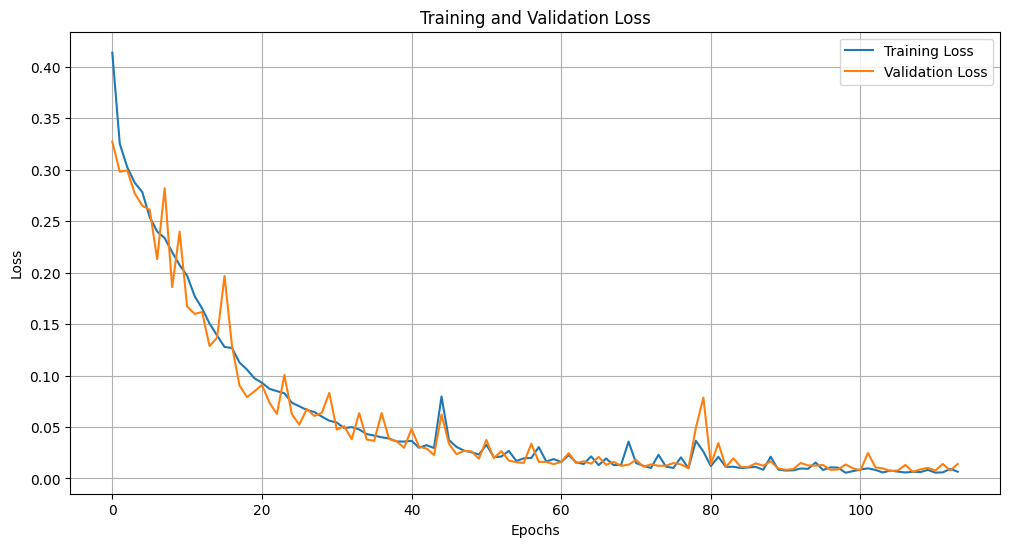

In [57]:
#plotting training, validation loss from history

plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")   #those values mean nothing.


5000/5000 [==============================] - 32s 6ms/step - loss: 0.0129 - binary_crossentropy: 0.0129
Test Loss: 0.01291024498641491
Test Accuracy: 0.01291024498641491


### Checking accuracy by thresholding the predictions on 0.5

In [23]:
# Predict on the test set
test_predictions = model.predict(X_test)

# Apply thresholding for binary results
threshold = 0.5
binary_test_predictions = (test_predictions > threshold).astype(int)


accuracy = accuracy_score(y_test, binary_test_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


313/313 [==============================] - 5s 10ms/step
Accuracy: 99.37%


---------------------

As we can see, the network converges well, ending vefore 120th epoch. Loss goes down to 0.012.<br>
<b>Accuracy</b> measured by putting a threshold on predictions is 99.37%. The threshold has to be put, since our predictions are values between 0-1 for each probability.

----------------------

In [24]:
#Creating df with predictions and real values to check if the predictions really match up. It seems so.
comparison_df = pd.DataFrame({
    'Factual': [list(row) for row in y_test],
    'Predicted': [list(row) for row in binary_test_predictions]
})
comparison_df  

Factual        Predicted
0     [0, 0, 1, 0, 0]  [0, 0, 1, 0, 0]
1     [0, 0, 0, 0, 0]  [0, 0, 0, 0, 0]
2     [0, 0, 1, 0, 1]  [0, 0, 1, 0, 1]
3     [0, 1, 1, 1, 0]  [0, 1, 1, 1, 0]
4     [0, 0, 0, 0, 0]  [0, 0, 0, 0, 0]
...               ...              ...
9995  [0, 0, 0, 0, 0]  [0, 0, 0, 0, 0]
9996  [0, 1, 1, 0, 1]  [0, 1, 1, 0, 1]
9997  [1, 0, 0, 0, 1]  [1, 0, 0, 0, 1]
9998  [1, 0, 1, 0, 1]  [1, 0, 1, 0, 1]
9999  [0, 0, 1, 1, 1]  [0, 0, 1, 1, 1]

[10000 rows x 2 columns]

## Matching predictions:

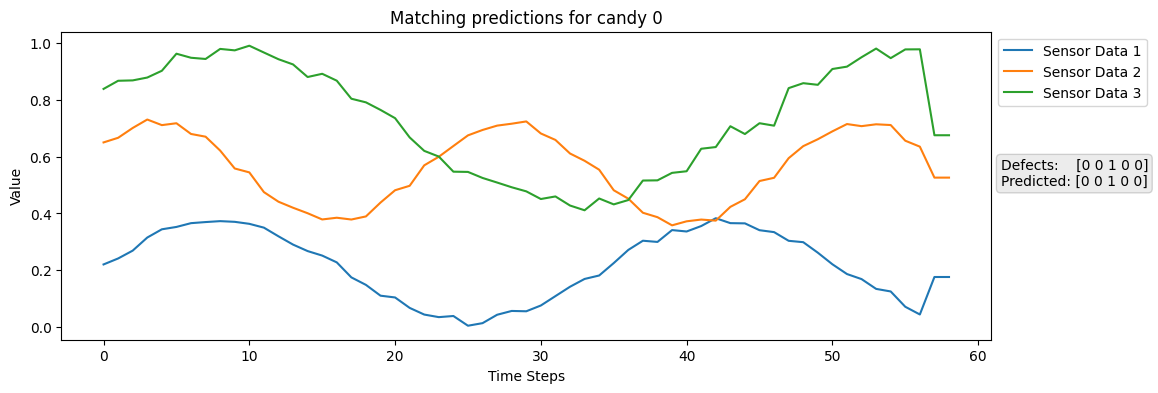

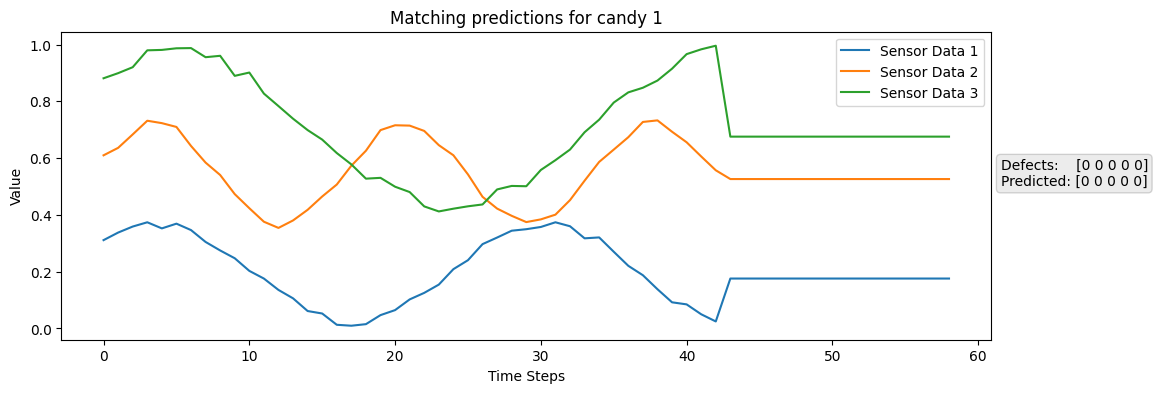

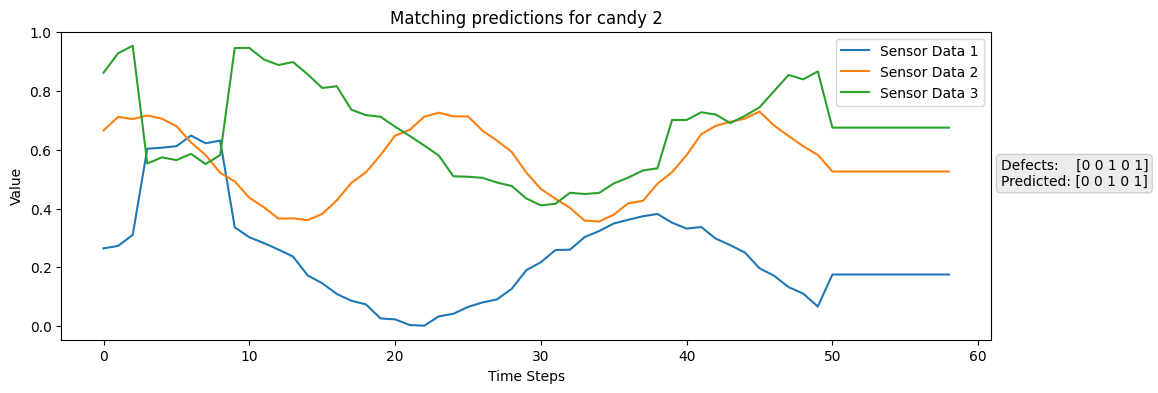

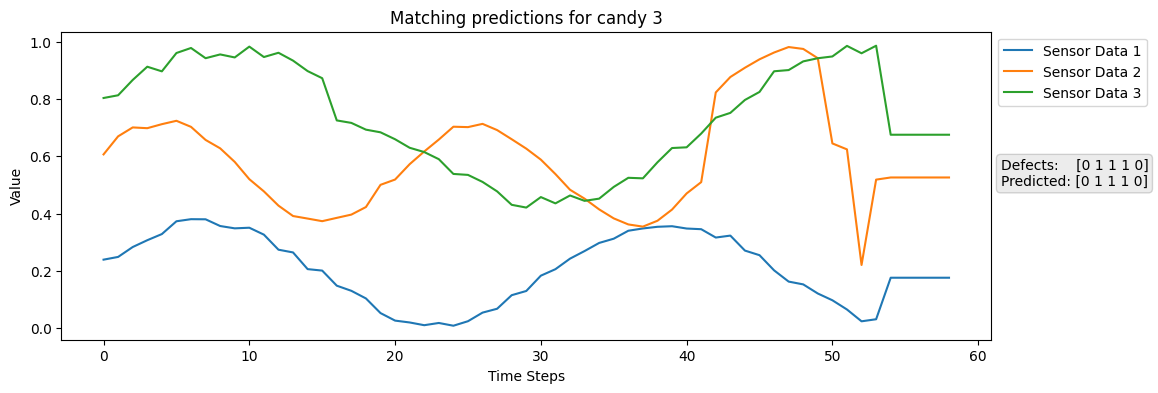

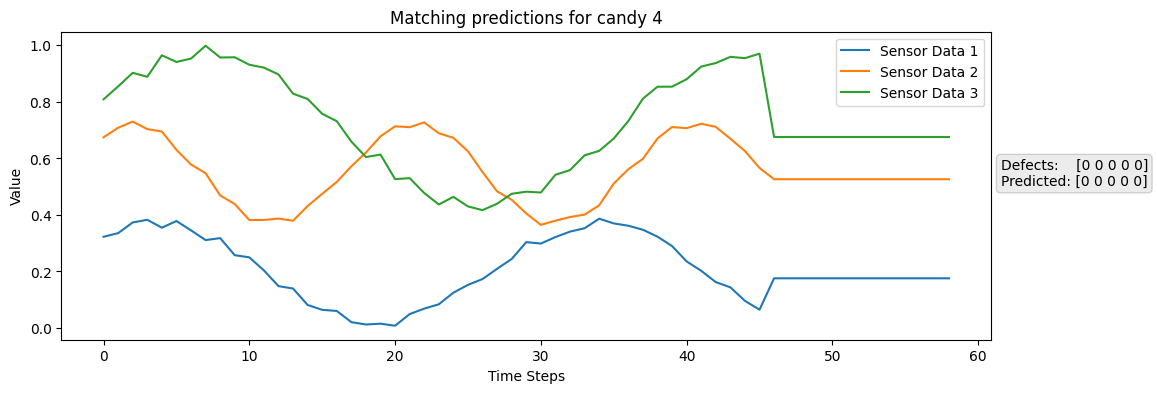

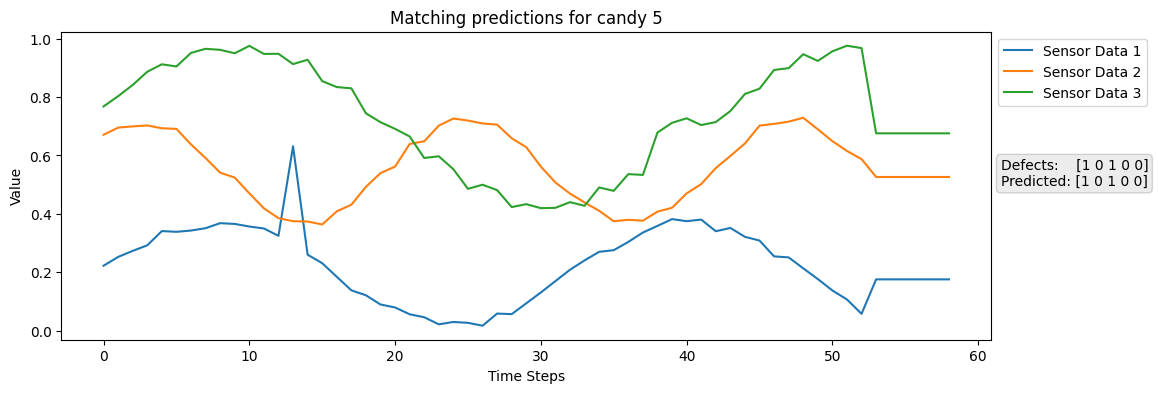

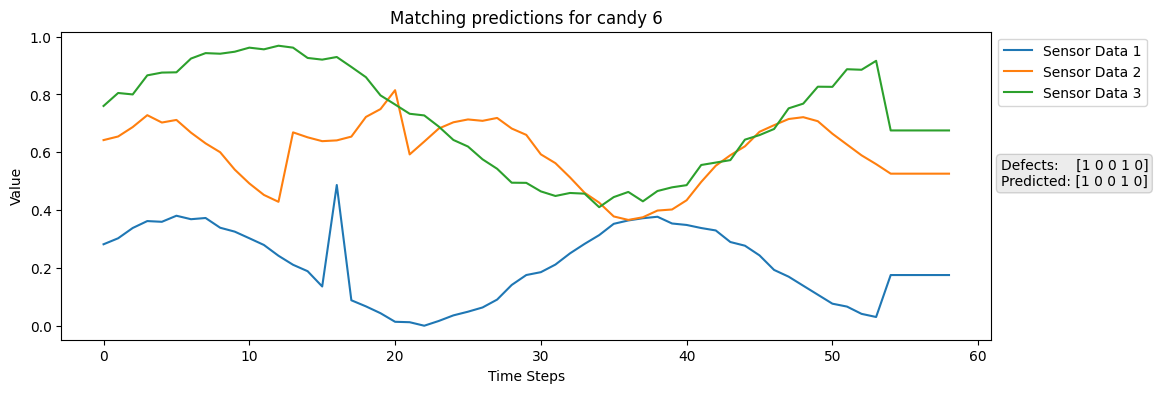

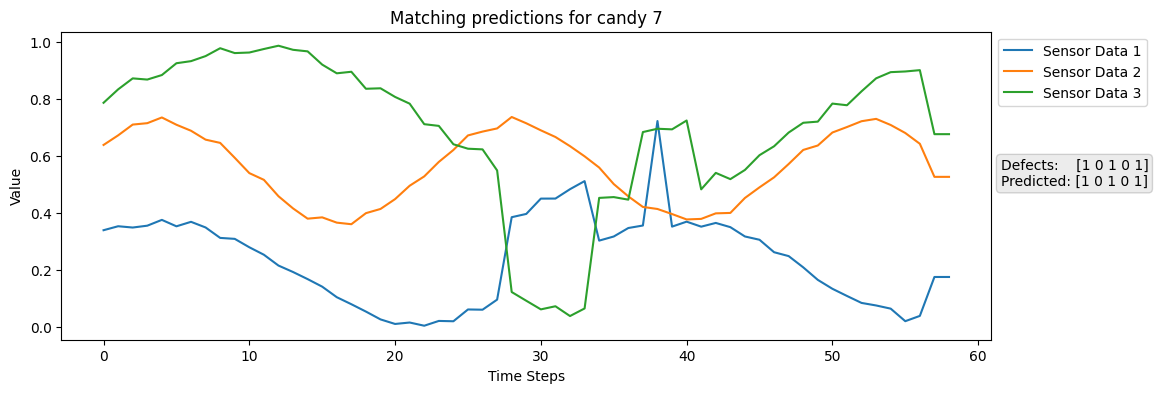

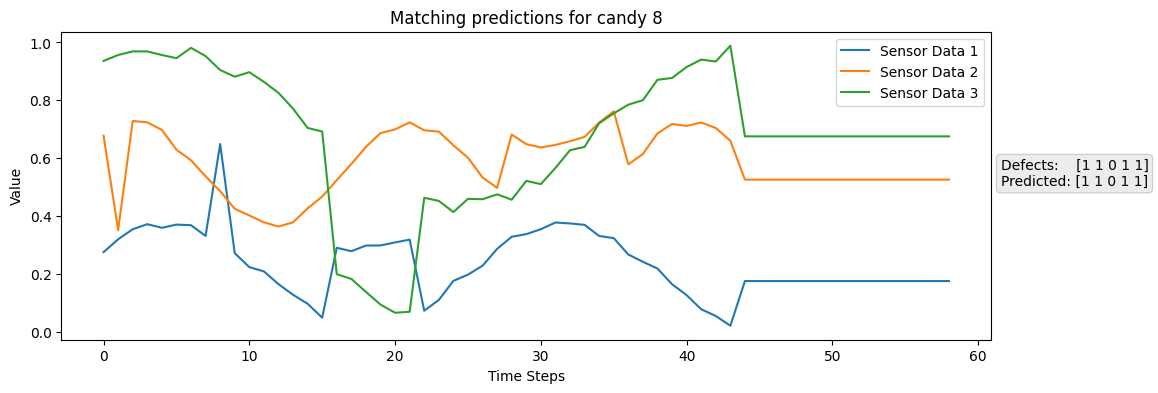

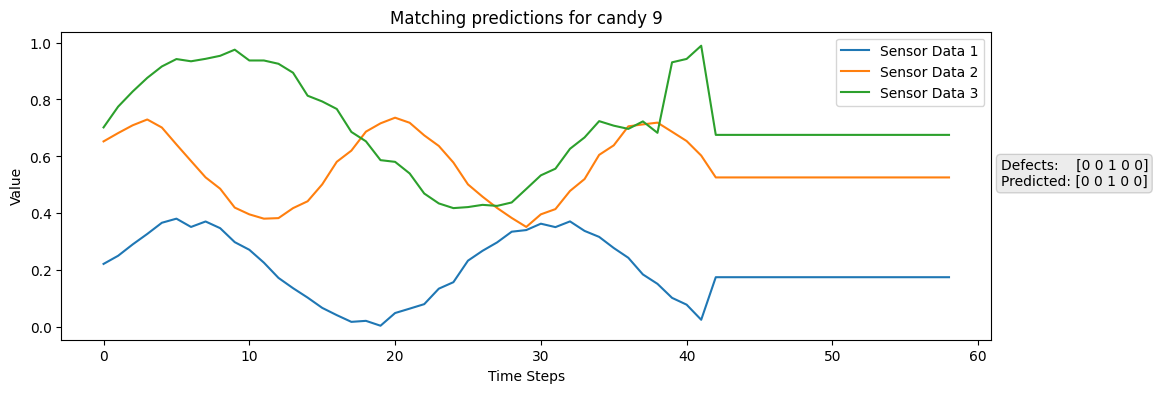

In [77]:
for i in range(10):
    if np.array_equal(y_test[i], binary_test_predictions[i]):
        plt.figure(figsize=(12, 4))
        plt.title(f"Matching predictions for candy {i}")
        
        for j in range(X_test.shape[2]):  
            plt.plot(X_test[i, :, j], label=f"Sensor Data {j+1}")
        # plt.plot(X_test[i], label="sensor data")
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
        plt.text(1.01, 0.5, f"Defects:    {y_test[i]}\nPredicted: {binary_test_predictions[i]}", fontsize = 10, bbox=props, transform=plt.gca().transAxes)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.show()

## Not well predicted cases examples: 

In [ ]:
for i in range(1000):
    if not np.array_equal(y_test[i], binary_test_predictions[i]):
        
        plt.figure(figsize=(12, 4))
        plt.title(f"Matching predictions for candy {i}")
        
        for j in range(X_test.shape[2]):  
            plt.plot(X_test[i, :, j], label=f"Sensor Data {j+1}")
        # plt.plot(X_test[i], label="sensor data")
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
        plt.text(1.01, 0.5, f"Defects:    {y_test[i]}\nPredicted: {binary_test_predictions[i]}", fontsize = 10, bbox=props, transform=plt.gca().transAxes)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.show()

From analysing data, we can deduct that :
1. anomaly is blue outlier
2. anomaly is orange outlier (dip)
3. anomaly is green sensor that has different value for length 4
4. anomaly is orange sensor that has higher value for length 8
5. anomaly is blue-green sensor anomaly. Green goes lower, while blue goes higher.

### Candy 13
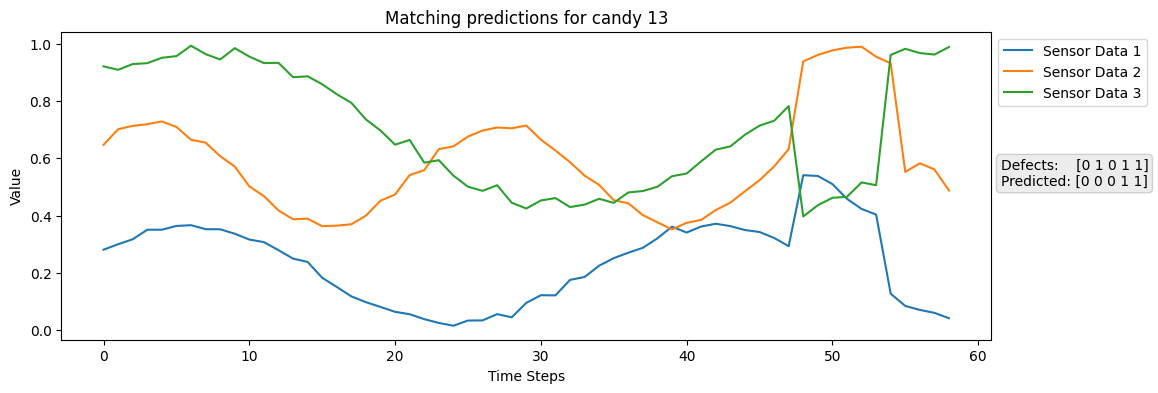

lack of orange dip outlier. To be honest, i dont even see it myself, maybe its around 55 time step, which mixes with anomaly of orange having higher value for 8 time steps. 

### Candy 264 
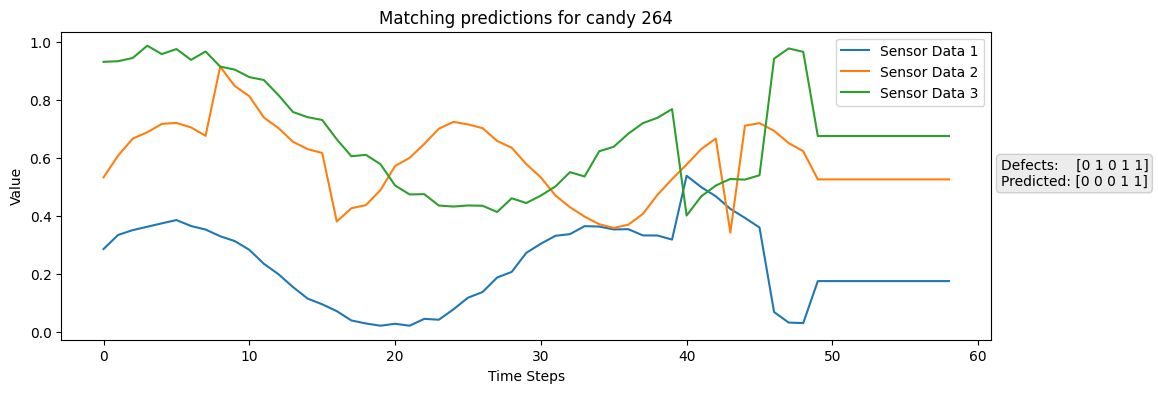

lack of orange dip outlier. This is clearly seen around 43 time step. The data from orange sensor seem to be already very noisy and full of anomalies. Maybe network couldn't work well with that.

### Candy 382
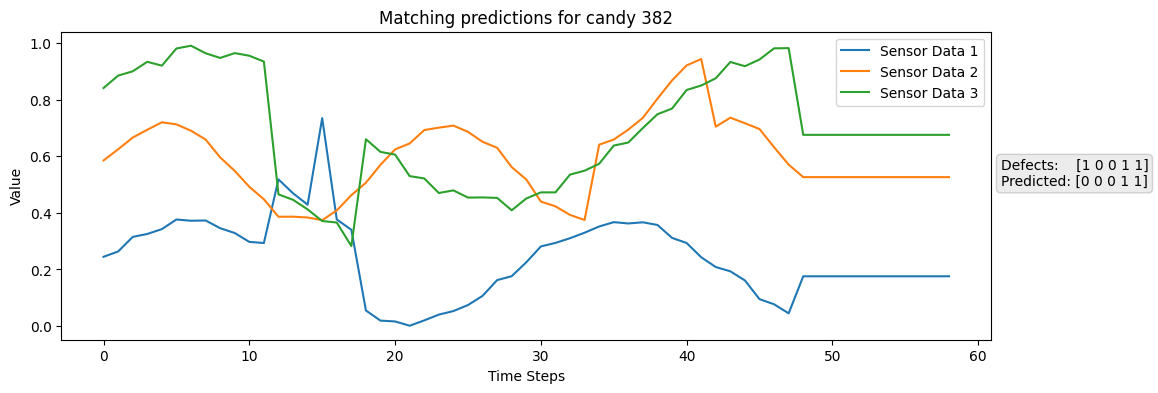

lack of blue outlier. The outlier can be seen around 15th time step. It is in the middle of blue-green tradeoff outlier. This is probably the reson for missclassification.

### Candy 611
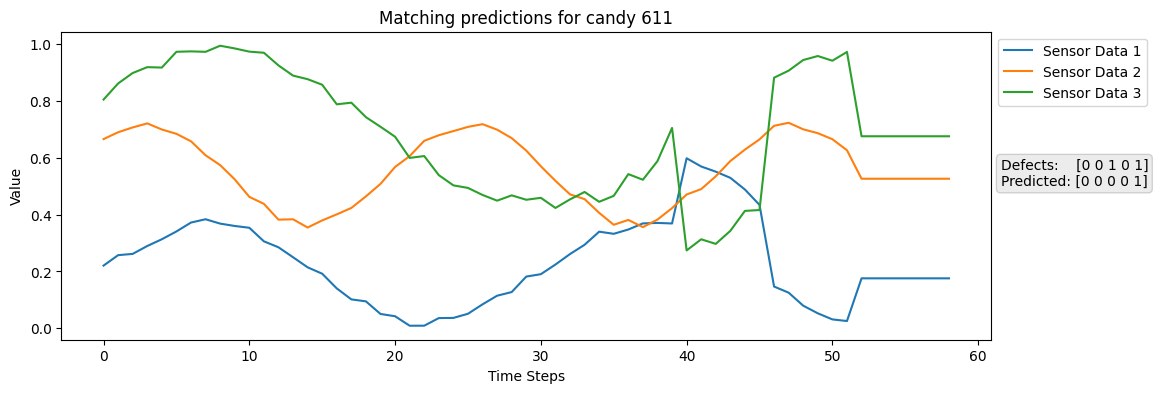

lack of green outlier of length 4. It is probably around 45-52 time step. It is a part that goes straight from blue-green tradeoff. Network might've confused that with natural flow of green, that goes back to its sinsusoidal nature after blue-green tradeoff.

### Candy 793
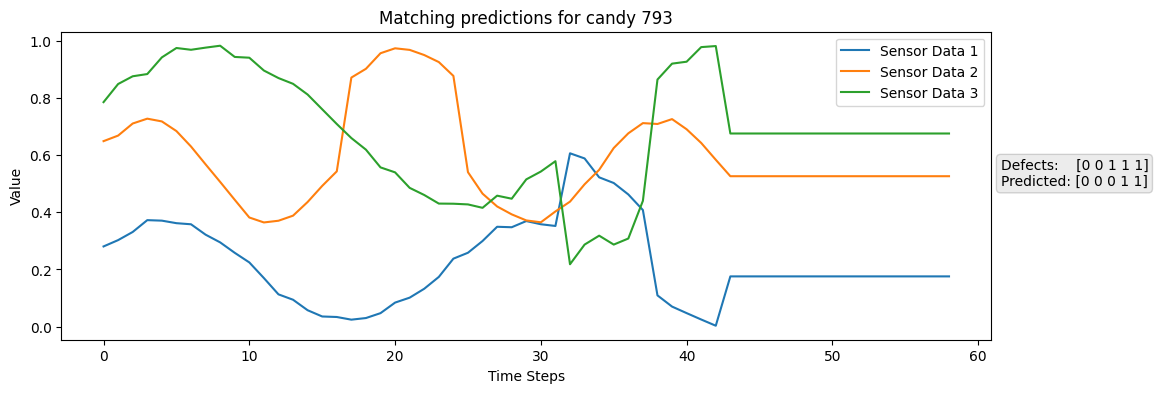

Lack of green outlier of length 4. It is the same case as before. 

In [82]:
mismatches = y_test != binary_test_predictions  # Element-wise comparison
mismatch_counts = mismatches.sum(axis=0)  # Count mismatches for each index

# Print mismatched indices and their counts
for i, count in enumerate(mismatch_counts):
    print(f"Index {i} has {count} mismatches.")

# Optional: Print overall mismatches
total_mismatches = mismatches.sum()
print(f"Total mismatches: {total_mismatches}")

Index 0 has 5 mismatches.
Index 1 has 6 mismatches.
Index 2 has 52 mismatches.
Index 3 has 0 mismatches.
Index 4 has 1 mismatches.
Total mismatches: 64


<span style="font-size:25px;"> As we can see, the worst predicted anomaly is the 3rd one, the green sensor of length 4 anomaly. In my opinion in understandable, as it is can look just a little off from how the sensor data should look like. It is still rising, it sometimes is right after the blue-green tradeoff, where it is even harder to see it ourselves, not to mention neural network. <br><br>
Best detected anomaly is 4rd one, the orange sensor of length 8. It is always easy to see, as the data is way off from the sinusoidal nature of data. It is longer peak, with plateau at the top. Always looks off. Hence, easy to learn for network
<br><br>
Overall, our network performs well, with only 64 mismatches in the whole data. One class is of particular trouble, which maybe could be adressed with some other preprocessing that uses the nature of the data. </span>
***

# Hyperparameter optimization
We are going to test:
- number of LSTM layers 1-3.
- Number of LSTM units: 32, 64, 128, 256
- Dropout rate: 0.1-0.5 every 0.1 step
- Batch size: 16, 32, 64
- Learning rate: 1e-4, 1e-3, 1e-2

In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Masking, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define HyperModel for Tuning
class AnomalyDetectionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Masking(mask_value=0, input_shape=(max_len, 3)))
        
        # Add LSTM layers
        for i in range(hp.Int('num_lstm_layers', 1, 3)):
            model.add(LSTM(units=hp.Choice(f'lstm_units_{i}', [32, 64, 128]), 
                           return_sequences=(i < hp.Int('num_lstm_layers', 1, 3) - 1)))
            model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

        # Add Dense output layer
        # model.add(Dense(5, activation=hp.Choice('activation', ['sigmoid', 'relu'])))
        model.add(Dense(5, activation='sigmoid'))
        
        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

# Initialize tuner
tuner = RandomSearch(
    AnomalyDetectionHyperModel(),
    objective='val_accuracy',
    max_trials=20,  # Number of models to test
    executions_per_trial=2,  # Number of times to train each model for robustness
    directory='tuner_logs',
    project_name='anomaly_detection_optimization'
)

X_subset, _, y_subset, _ = train_test_split(
    X_train, y_train, test_size=0.8, stratify=y_train, random_state=42
)

# Perform hyperparameter search
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
tuner.search(
    X_subset, y_subset,
    epochs=80,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


# Get the best model
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

# Save the best model
best_model.save("optimized_model_candy.keras")

# Print best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)


### I performed the tuning in google collab, so here are results:

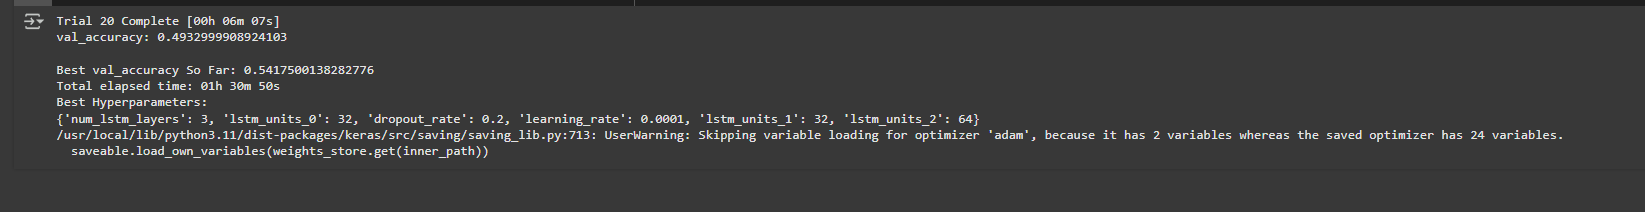


#### Outputs:
- LSTM layers: 3
- LSTM units: 32, 32, 64
- Dropout rate: 0.2
- Learning rate: 0.0001

Performing this optimization was unnecessary, and I didn't apply the results, because our network learned very well without the more layers. Applying the results of hyperparameter optimization would mean leff efficiency, and not so much more accuracy. The data is too simple for optimization like that.
****

# Explainability
## I show each tried method, with various success. Best methods are at the end. Each method has some conclusions and last ones have analysys of 8 examples each


## 1. Seasonal decompose
First i wanted to check if the data was possible to analyze with seasonal decompose, but the different period of series and noise in data makes it not worth trying further. 

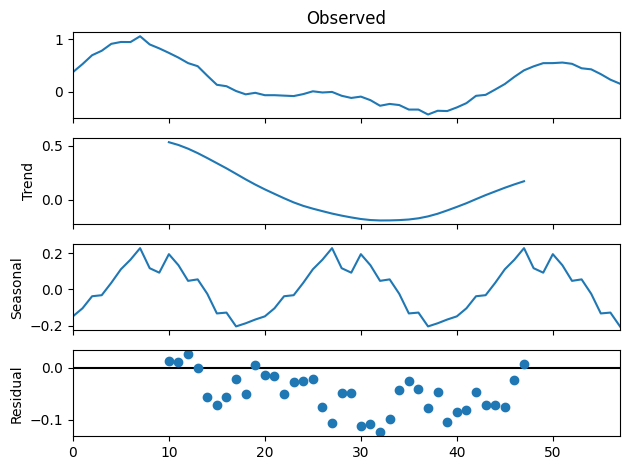

Residual anomalies for series 0:
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.01293998  0.00964406
  0.02576449 -0.00016063 -0.05581772 -0.07278515 -0.05717185 -0.02195804
 -0.05135752  0.00490744 -0.01374028 -0.01695575 -0.05160071 -0.02746578
 -0.02653773 -0.02231092 -0.07500975 -0.10603419 -0.04938161 -0.04938161
 -0.1117032  -0.10840728 -0.12452771 -0.09860259 -0.04294551 -0.02597807
 -0.04159137 -0.07680519 -0.0474057  -0.10367066 -0.08502294 -0.08180747
 -0.04716251 -0.07129744 -0.07222549 -0.07645231 -0.02375348  0.00727096
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]


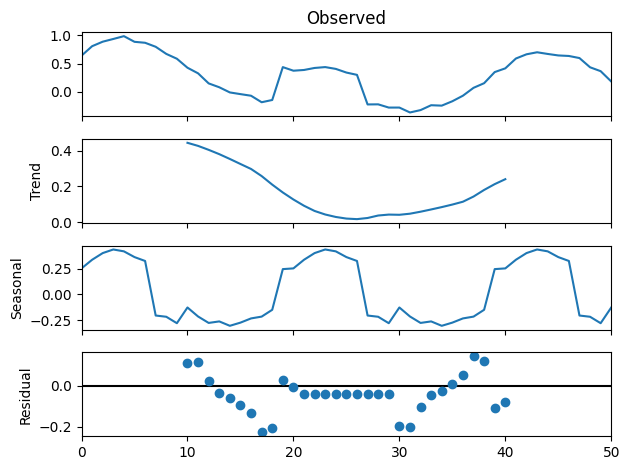

Residual anomalies for series 1:
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.1093213   0.11495
  0.02130853 -0.0377231  -0.05985938 -0.09250047 -0.13410455 -0.22714188
 -0.20583487  0.02522075 -0.00619729 -0.04212095 -0.04212095 -0.04212095
 -0.04212095 -0.04212095 -0.04212095 -0.04212095 -0.04212095 -0.04212095
 -0.19356321 -0.1991919  -0.10555043 -0.0465188  -0.02438252  0.00825856
  0.04986264  0.14289998  0.12159296 -0.10946266 -0.07804461         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan]


In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i, (x,y) in enumerate(zip(xl[:2], yl[:2])):
    if any(str(val).lower() == "true" for val in y):
        row_flat = x.mean(axis=1)  
        # Flatten row into a 1D array for decomposition
        result = seasonal_decompose(row_flat, model='additive', period=20)  # Adjust period as needed
        
        # Plot decomposition
        result.plot()
        plt.show()

        # Analyze residuals
        residuals = result.resid
        print(f"Residual anomalies for series {i}:")
        print(residuals)


***
***

# Neural network options:
 2. Attention
 3. tf.gradient()
 4. time steps masking - Best
 5. time steps masking for each label - Best 2.0

***
# 2. Attention

Attention mechanism is method that determines the relative importance of each component in a sequence relative to other components in a sequence. 
Adding attention layer to our network let's us extract imprortance of particular parts of sequences.<br>
We turn return sequences true in LSTM layer. Then, we put those sequences through Attention layer. For Dense layer to work, we need to flatten data, and we do so by using Glogal Max Pooling- extracting max from the attention.<br>
There is also small change in number of LSTM units-50. All others parameters are the same as in previous network.

<br> It doesn't provide satisfactory results, but im showing it either way. I think that there is some problem with architecture, but couldn't figure it out.

In [95]:
from keras.models import Model
from keras.layers import LSTM, Dense, Attention, GlobalMaxPooling1D

## This gives only attention for last series of points.

# Example of LSTM with Attention
inputs = Input(shape=(X_train[0].shape[0], X_train[0].shape[1]))
masked_input = Masking(mask_value=0)(inputs)
lstm = LSTM(50, return_sequences=True, kernel_initializer = initializer)(masked_input)
attention = Attention()([lstm, lstm])
pooled_attention = GlobalMaxPooling1D()(attention)
output = Dense(5, activation='sigmoid')(pooled_attention)

atten = Model(inputs, output)
atten.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])
atten.summary()

callbacks = EarlyStopping(monitor="loss", patience=15, restore_best_weights= True)

# TRAINING AND SAVING
# Training the model
# attention_hist = atten.fit(X_train, y_train, epochs=120, batch_size=32, validation_data=(X_val, y_val), callbacks = [callbacks])

# atten.save("model_attention.keras")
# with open('attention_hist.pkl', 'wb') as f:
#     pickle.dump(attention_hist.history, f)
 
#LOADING

atten = load_model("model_attention.keras")
with open('attention_hist.pkl', 'rb') as f:
    attention_hist = pickle.load(f)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 59, 3)]              0         []                            
                                                                                                  
 masking_5 (Masking)         (None, 59, 3)                0         ['input_5[0][0]']             
                                                                                                  
 lstm_5 (LSTM)               (None, 59, 50)               10800     ['masking_5[0][0]']           
                                                                                                  
 attention_4 (Attention)     (None, 59, 50)               0         ['lstm_5[0][0]',              
                                                                     'lstm_5[0][0]']       

> We have 11k trainable paramters, less thanks to 50 instead of 64 LSTM units.

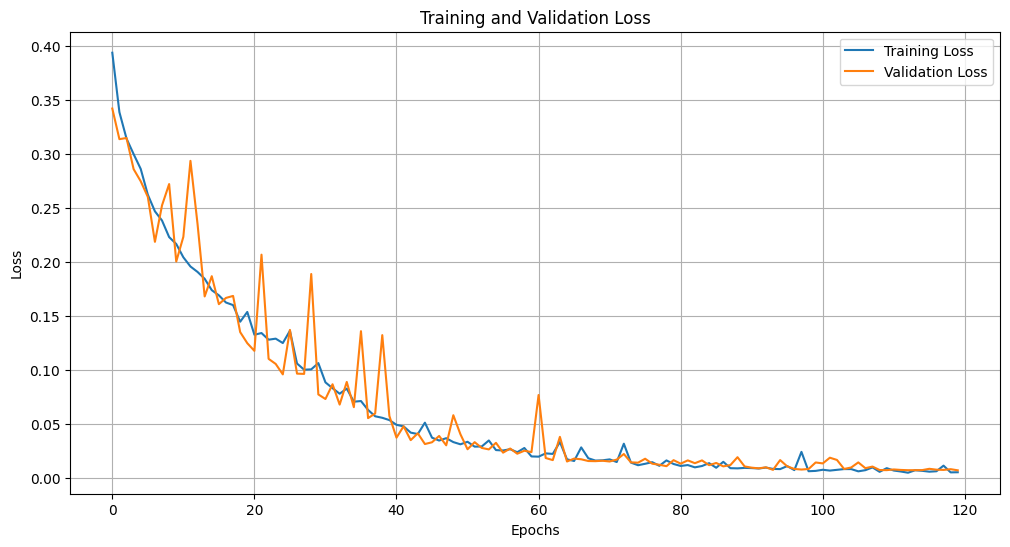

In [96]:
#plotting training, validation loss from history

plt.figure(figsize=(12, 6))
plt.plot(attention_hist['loss'], label='Training Loss')
plt.plot(attention_hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [97]:
# Predict on the test set
atten_pred = atten.predict(X_test)

# Apply thresholding for binary results
threshold = 0.5
binary_atten_pred = (atten_pred > threshold).astype(int)


accuracy = accuracy_score(y_test, binary_atten_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


313/313 [==============================] - 5s 12ms/step
Accuracy: 99.04%


#### The accuracy is 99% and convergence of loss function is well done. Network predicts well then. 


### Visualisation of results

We get values from globalMaxPooling layer, which should extract max of attention in each time step. This doesn't give results we would expect. Im not sure whats wrong, whether its parameters, max pooling (maybe average would work better?) or just that the method isn't good enough for us.

1/1 [==============================] - 1s 1s/step
defects: [0 0 1 0 0]


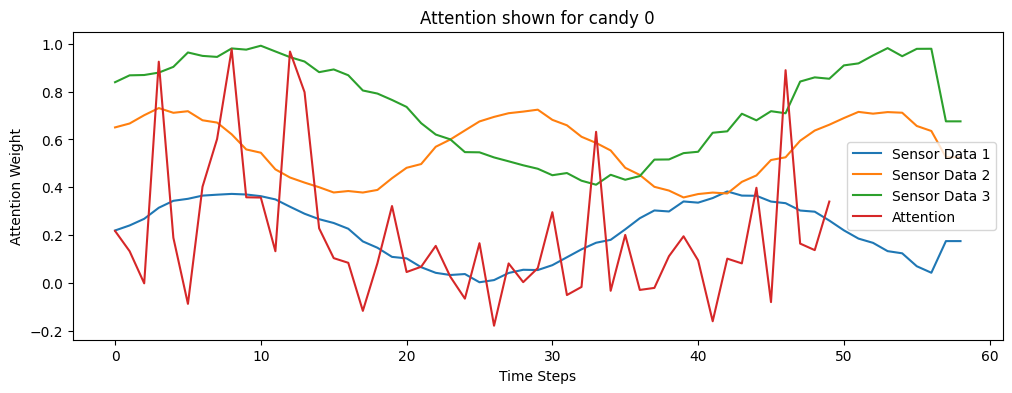

defects: [0 0 0 0 0]


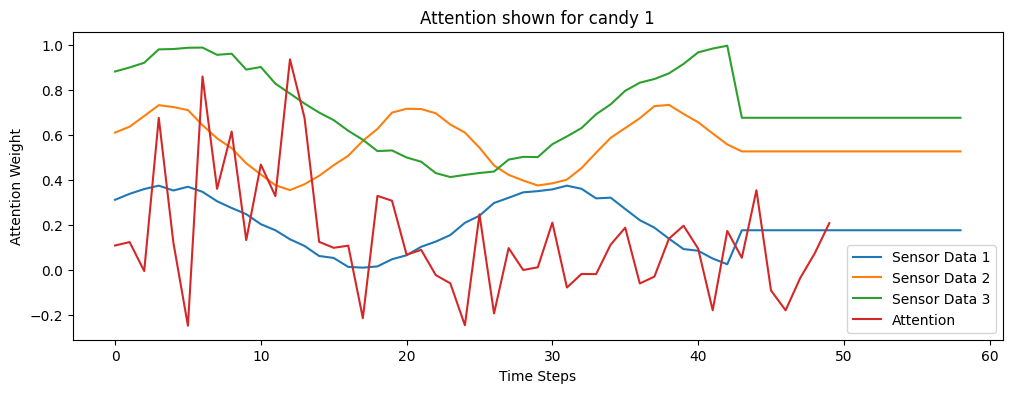

defects: [0 0 1 0 1]


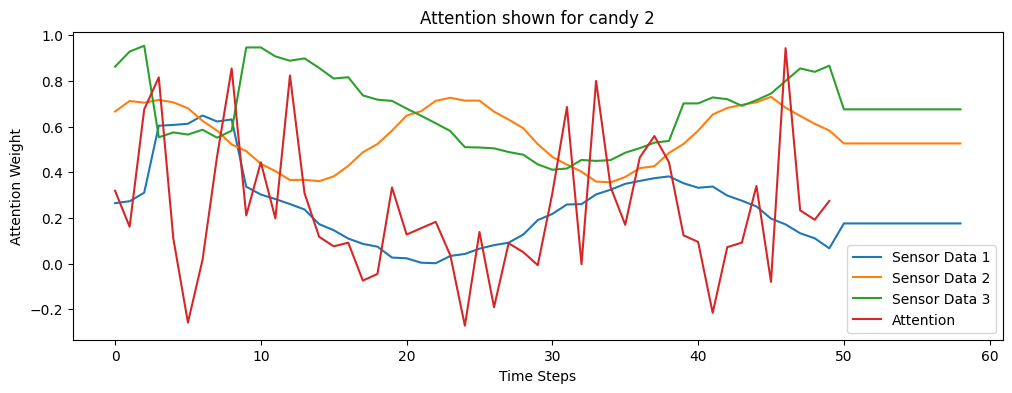

defects: [0 1 1 1 0]


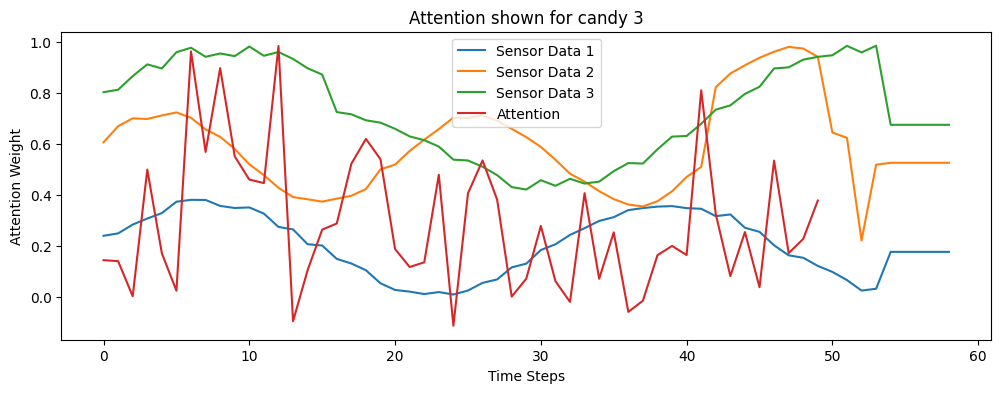

defects: [0 0 0 0 0]


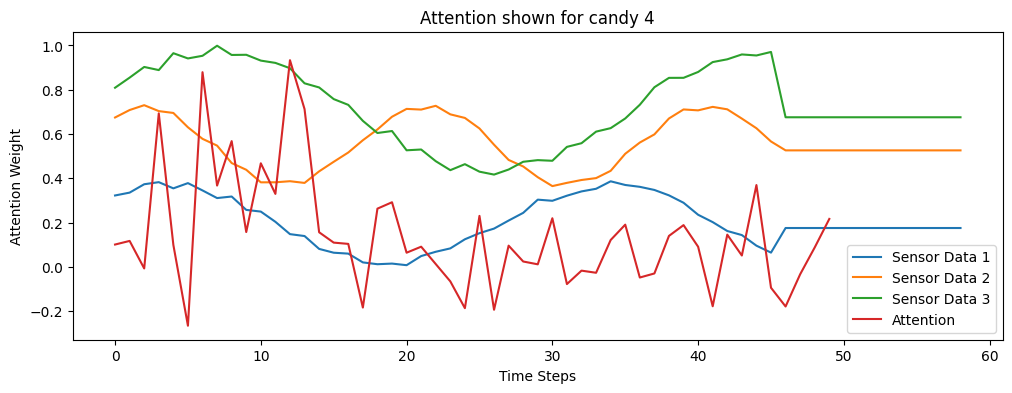

defects: [1 0 1 0 0]


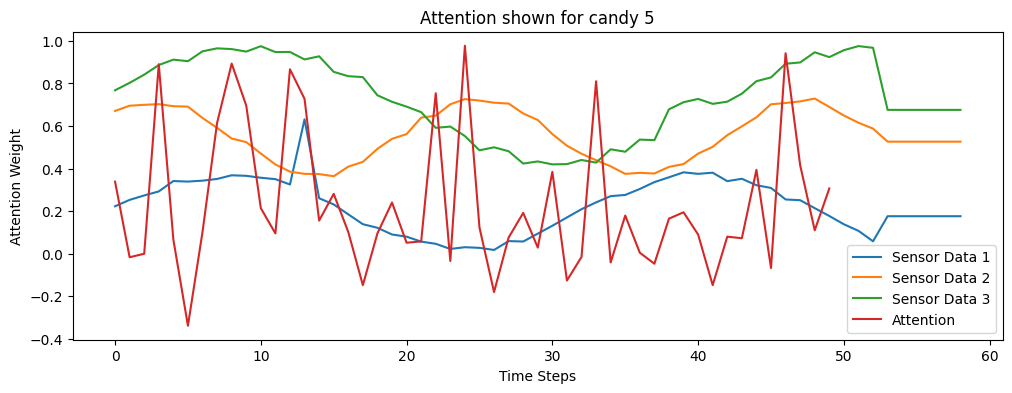

defects: [1 0 0 1 0]


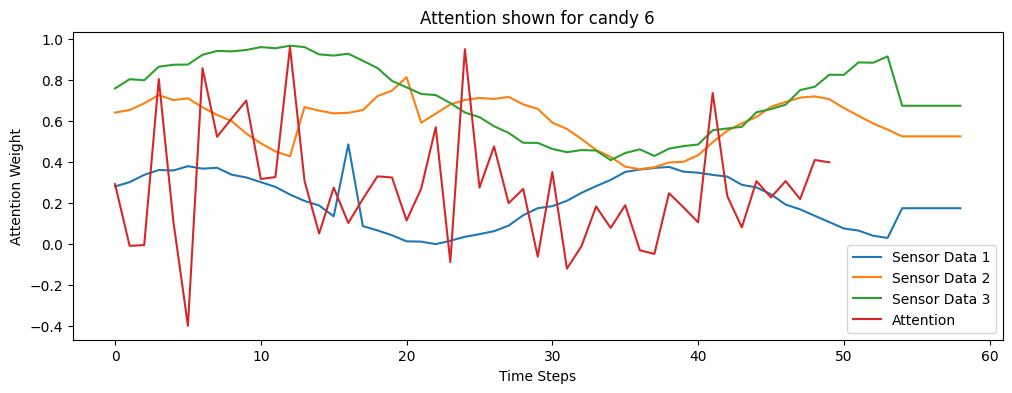

defects: [1 0 1 0 1]


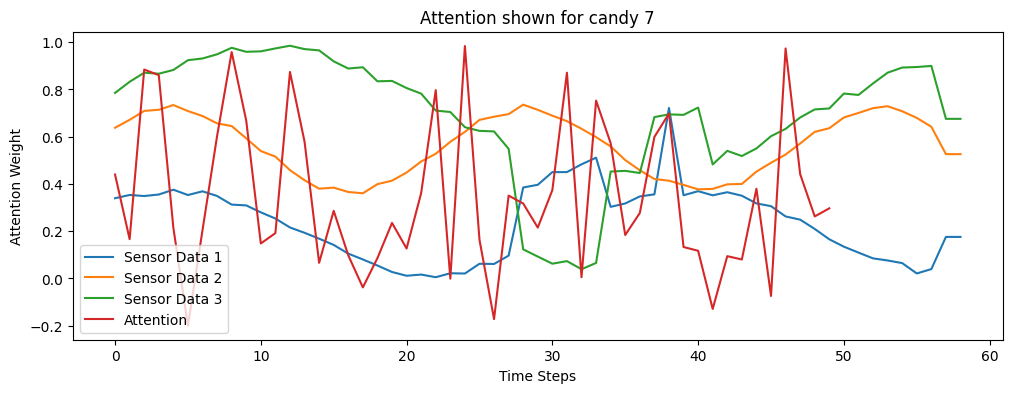

defects: [1 1 0 1 1]


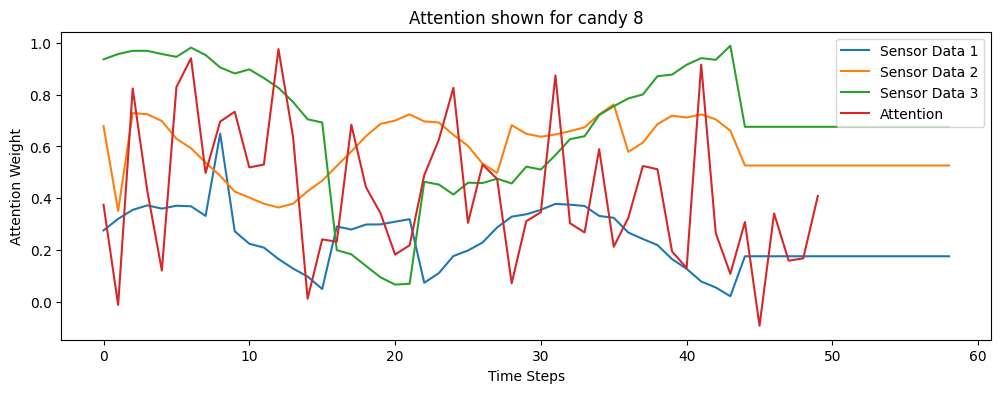

defects: [0 0 1 0 0]


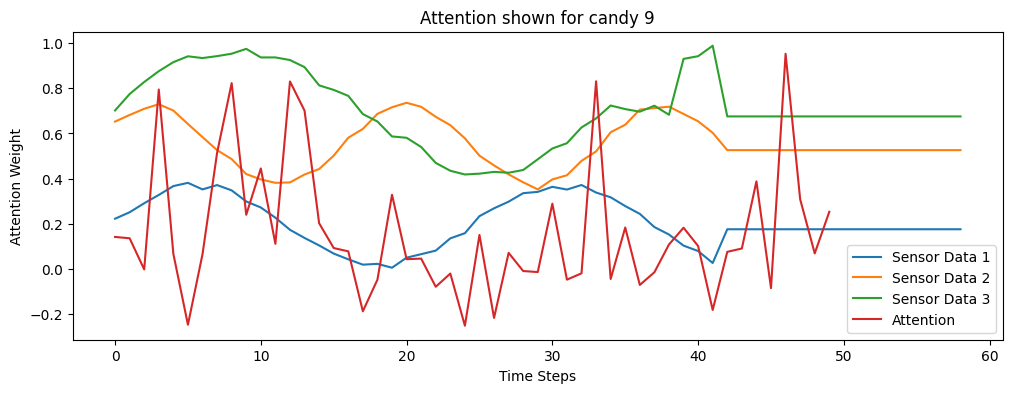

In [129]:
   
# Attention visualization
attention_layer = Model(inputs=[atten.input], outputs=[atten.get_layer('global_max_pooling1d_1').output])
attention_weights = attention_layer.predict(X_test[:15])
# print(attention_weights)


#Visualizing attention against sensor data
for i in range(len(X_test[:10])):
    plt.figure(figsize=(12, 4))
    plt.title(f"Attention shown for candy {i}")
    
    for j in range(X_test.shape[2]):  
        plt.plot(X_test[i, :, j], label=f"Sensor Data {j+1}")
    # plt.plot(X_test[i], label="sensor data")
    plt.plot(attention_weights[i], label="Attention")
    print(f"defects: {y_test[i]}")
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel('Attention Weight')
    plt.show()


## Computing attention weights using LSTM outputs
The attention scores are computed by taking the dot product of the LSTM outputs (keys and queries), resulting in a similarity matrix. This matrix is then passed through a softmax function to normalize the scores, turning them into attention weights (probabilities) that sum to 1 across time steps.
> This also doesn't provide any results that make sense.

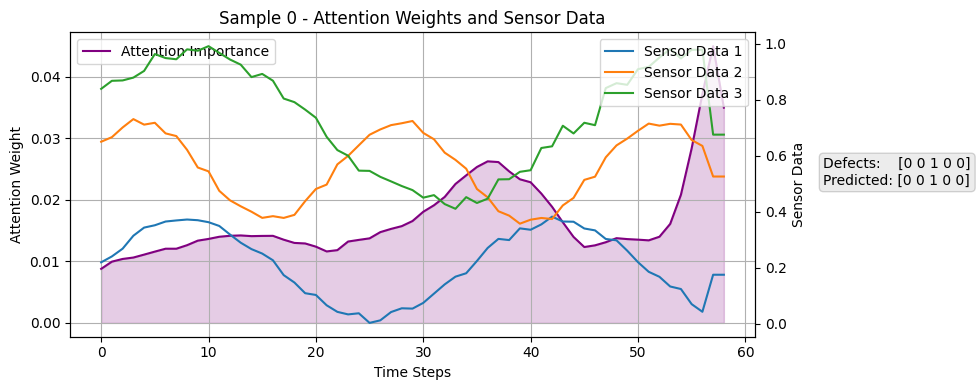

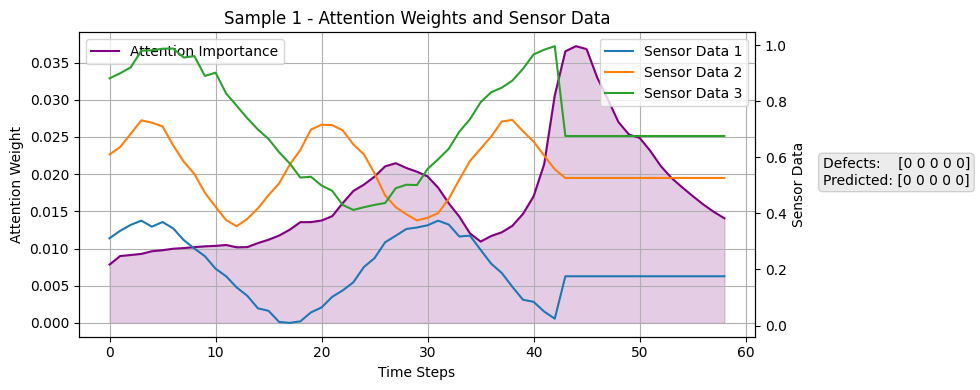

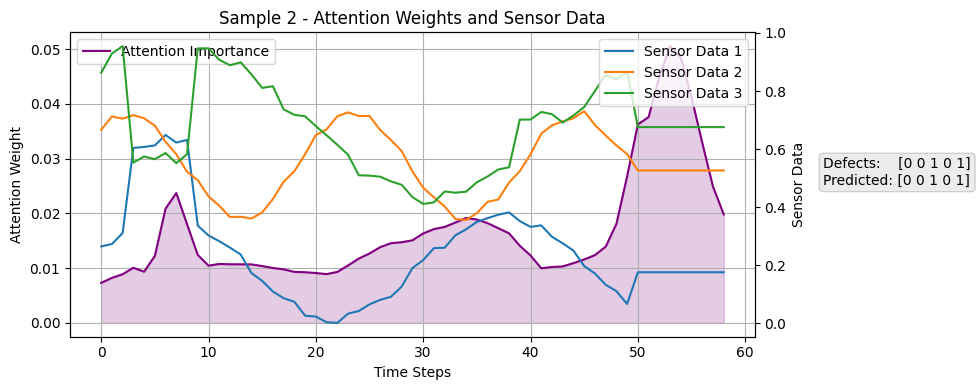

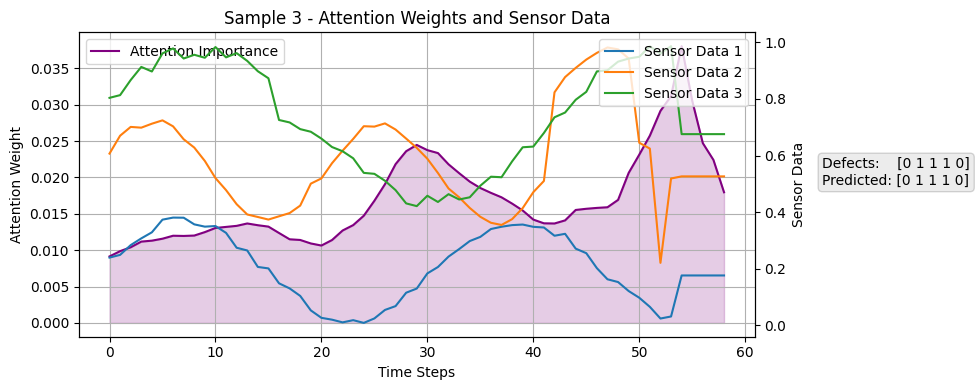

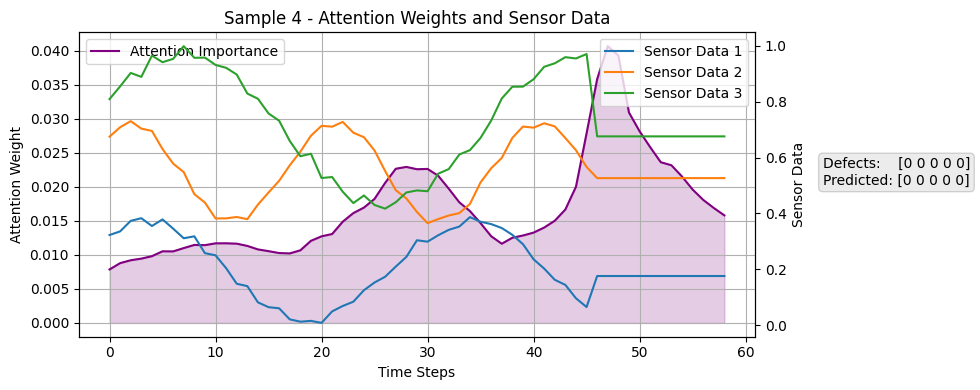

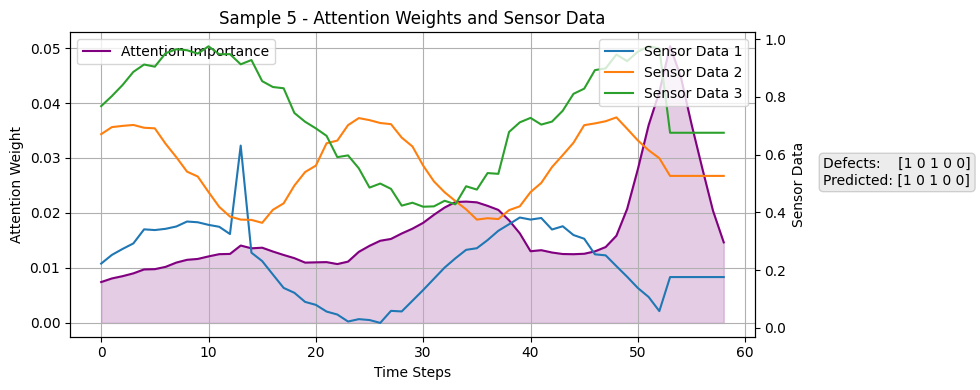

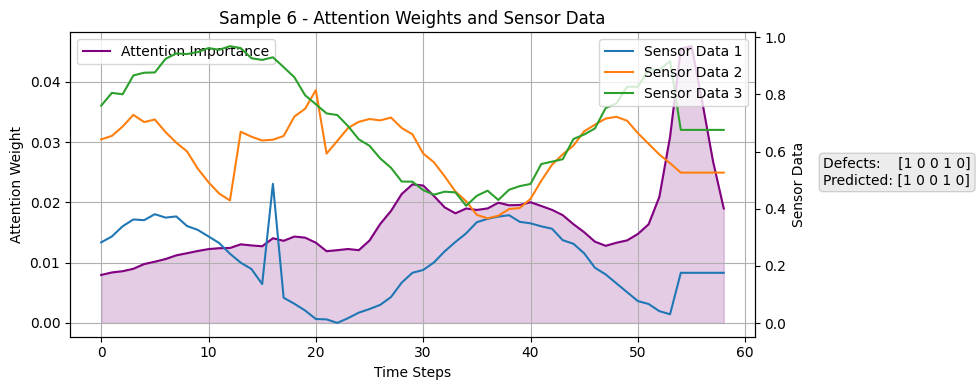

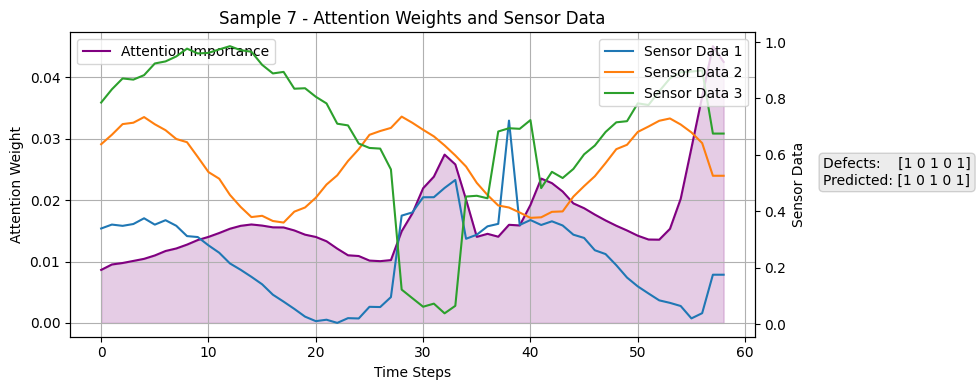

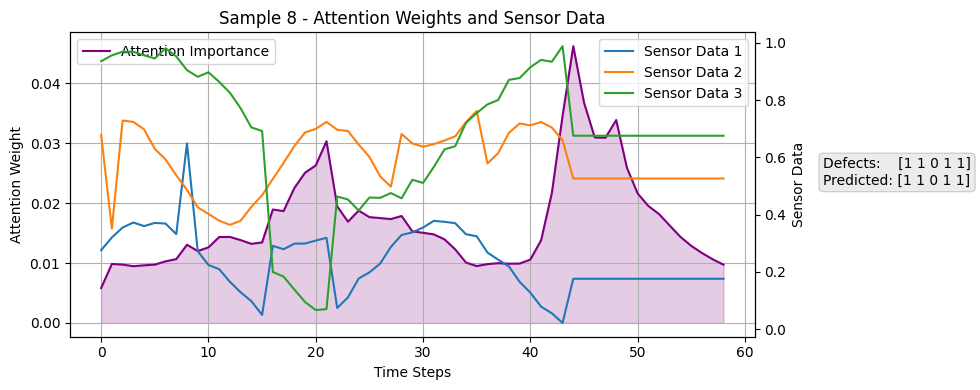

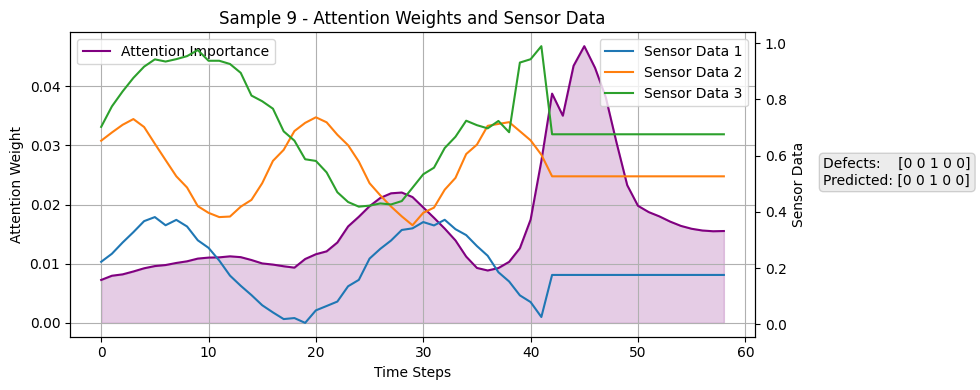

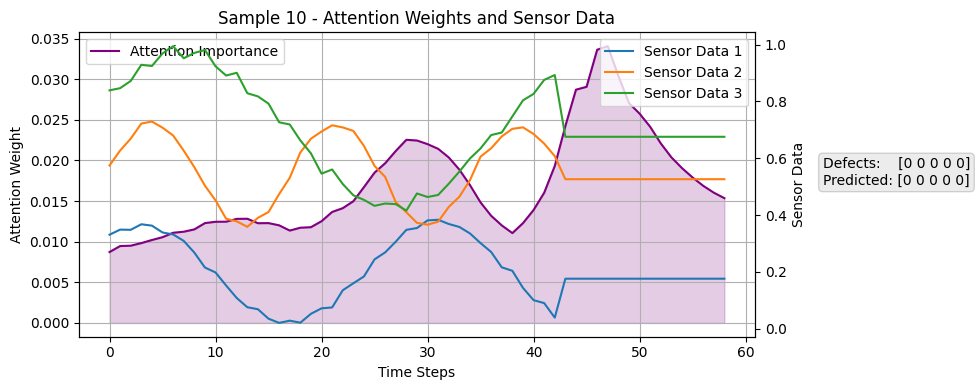

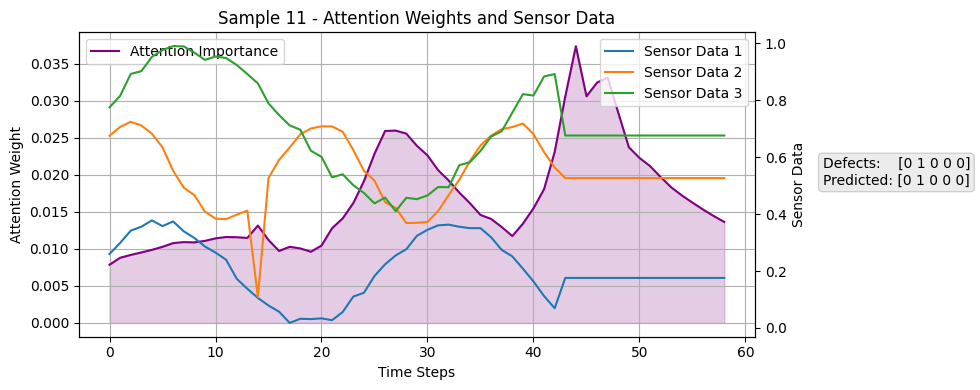

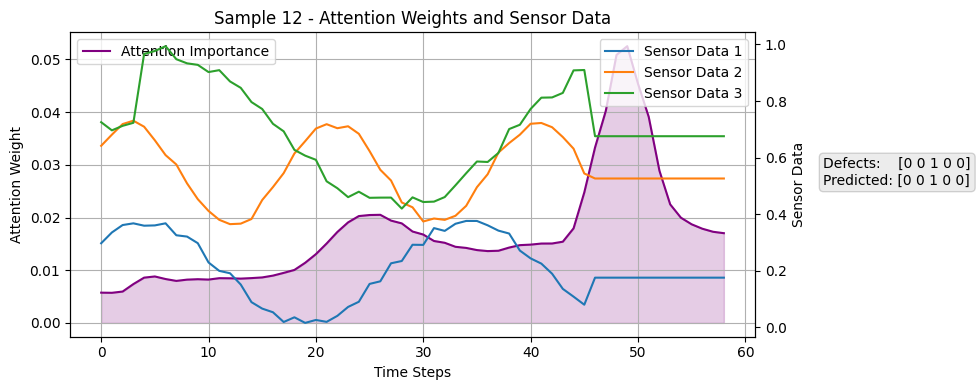

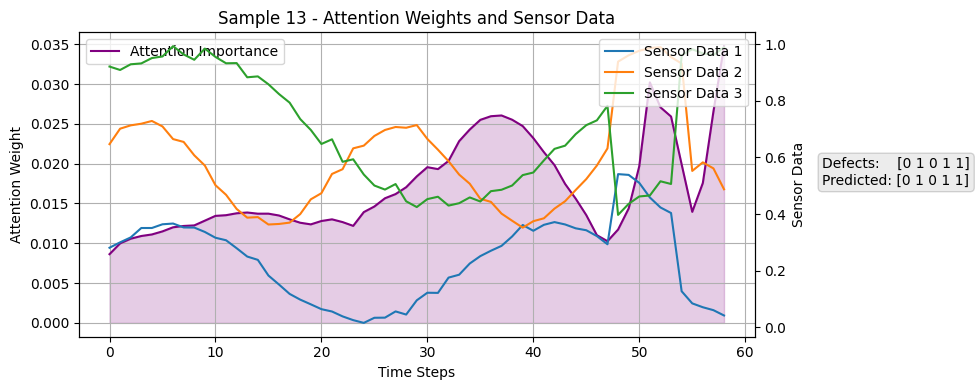

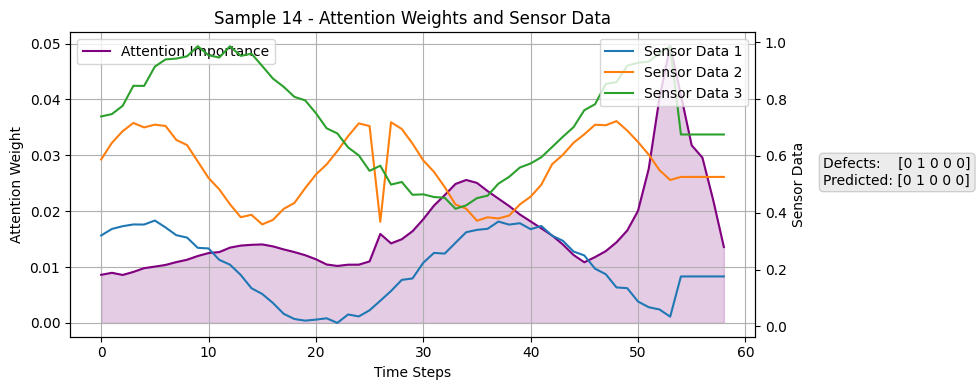

In [132]:
from keras.models import Model

# Define a new model to extract the LSTM and Attention outputs
attention_layer = Model(
    inputs=atten.input, 
    outputs=[atten.get_layer("attention_3").output, atten.get_layer("lstm_5").output]
)

def compute_attention_weights(lstm_output):
    """
    Compute attention weights given the LSTM output (keys and queries).
    Args:
        lstm_output: np.array of shape (batch_size, timesteps, features)
    Returns:
        attention_weights: np.array of shape (batch_size, timesteps)
    """
    query = lstm_output  # Shape: (batch_size, timesteps, features)
    key = lstm_output  # Same as query
    
    # Dot product attention score
    scores = np.matmul(query, key.transpose(0, 2, 1))  # Shape: (batch_size, timesteps, timesteps)
    
    # Normalize scores using softmax
    attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    return attention_weights

# Visualize attention weights for the first 15 samples
# Visualize attention weights and sensor data for the first 15 samples in one plot
for i in range(15):  # Iterate over the first 15 samples
    # Predict attention and LSTM outputs for the current sample
    attention_output, lstm_output = attention_layer.predict(X_test[i:i+1], verbose=0)  # Predicting one sample (batch size = 1)
    
    # Extract attention weights for the current sample
    sample_attention_weights = compute_attention_weights(lstm_output)[0]  # Shape: (timesteps, timesteps)
    
    # Compute the average attention for each time step (optional if scores are symmetric)
    time_step_importance = sample_attention_weights.mean(axis=0)  # Shape: (timesteps,)
    
    # Get prediction for the current sample
    pred = atten.predict(X_test[i:i+1], verbose=0)  # Predicting one sample (batch size = 1)
    binary_pred = (pred > 0.5).astype(int)  # Assuming binary classification
    
    # Create a single figure with 2 subplots: one for attention and one for sensor data
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # Plot attention weights as a line plot on the first subplot
    ax1.plot(time_step_importance, label="Attention Importance", color='purple')
    ax1.fill_between(range(len(time_step_importance)), time_step_importance, color='purple', alpha=0.2)
    ax1.set_xlabel("Time Steps")
    ax1.set_ylabel("Attention Weight")
    ax1.set_title(f"Sample {i} - Attention Weights and Sensor Data")
    ax1.grid()
    ax1.legend(loc="upper left")
    
    # Create a second y-axis to plot sensor data
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
    
    # Plot sensor data on the second y-axis
    for j in range(X_test.shape[2]):
        ax2.plot(X_test[i, :, j], label=f"Sensor Data {j+1}")
    
    ax2.set_ylabel("Sensor Data")
    ax2.legend(loc="upper right", bbox_to_anchor=(1.0, 1.0))
    
    # Add textual information about defects and predictions
    props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
    ax2.text(1.1, 0.5, f"Defects:    {y_test[i]}\nPredicted: {binary_pred[0]}", 
             fontsize=10, bbox=props, transform=ax2.transAxes)
    
    # Show the final plot
    plt.tight_layout()  # Ensure everything fits within the figure
    plt.show()


In [ ]:
# Predict on the test set
test_predictions = model.predict(X_test)

# Apply thresholding for binary results
threshold = 0.5
binary_test_predictions = (test_predictions > threshold).astype(int)


accuracy = accuracy_score(y_test, binary_test_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


313/313 [==============================] - 5s 10ms/step
Accuracy: 99.37%


****
# 3. Using tf.GradientTape- not  good

This method calculates importance of each time step in the input data for each sensor by examining the gradient of the model's output with respect to the input using TensorFlow's GradientTape. It doesn't work well, below see results. Possibly, the gradiesnts in model are just so weirdly computed. 

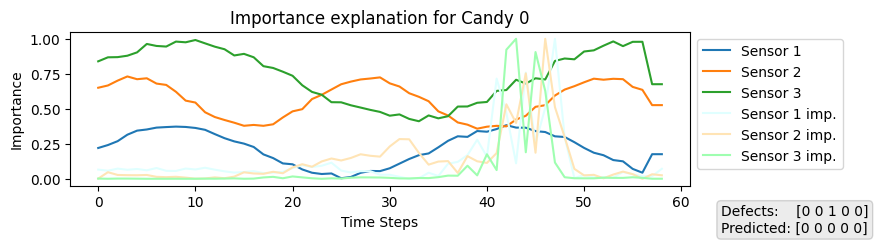

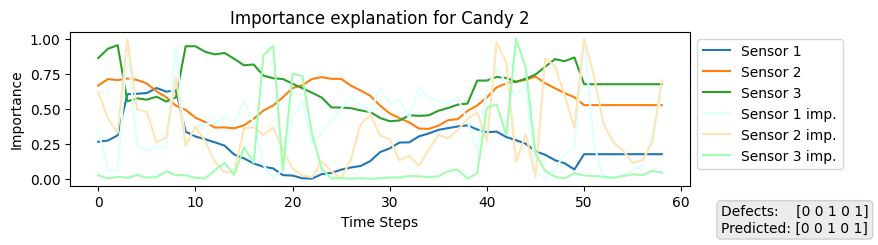

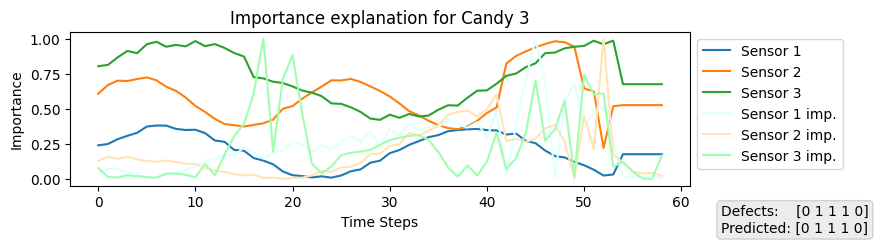

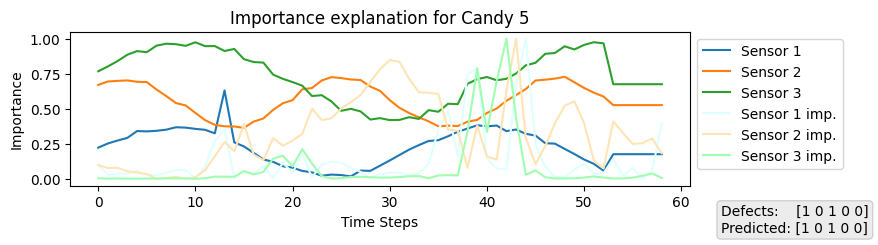

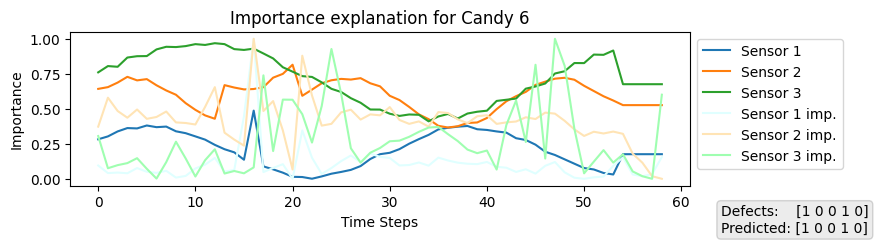

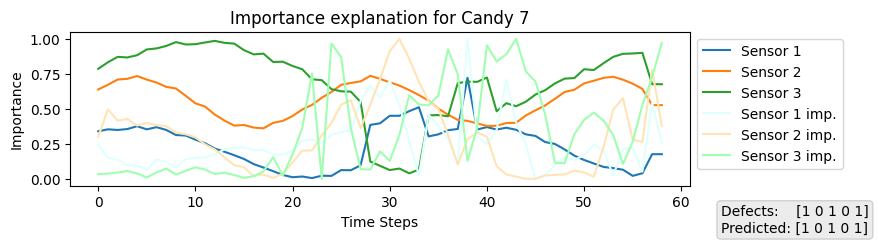

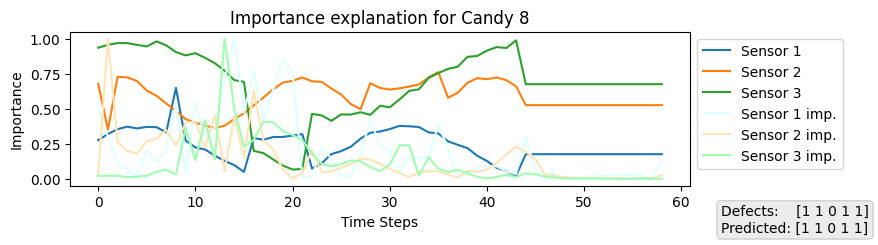

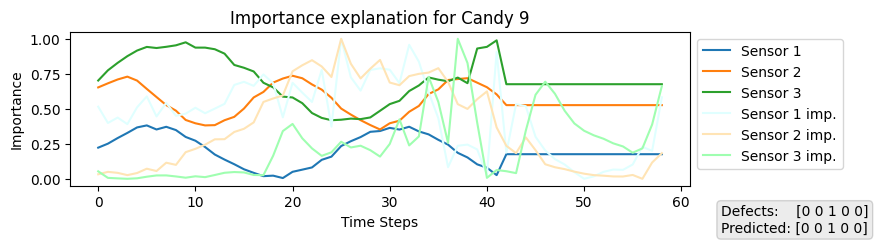

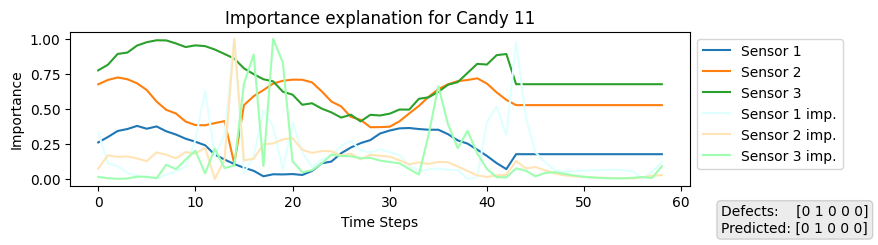

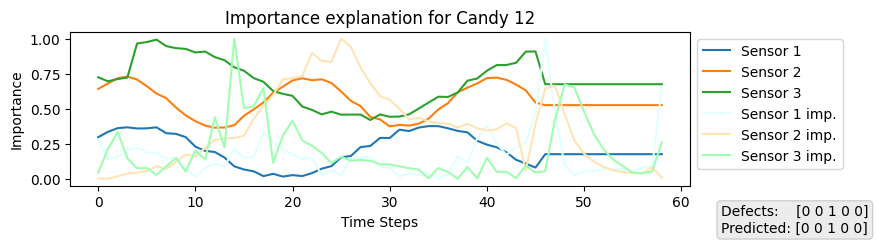

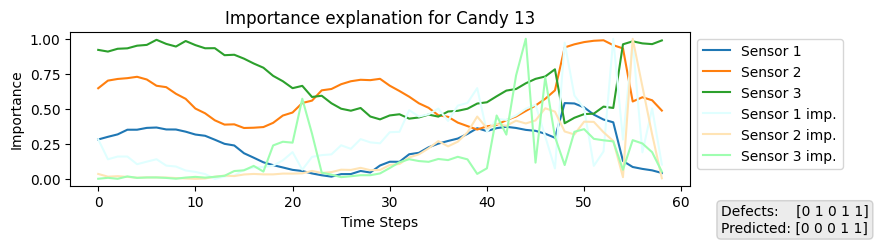

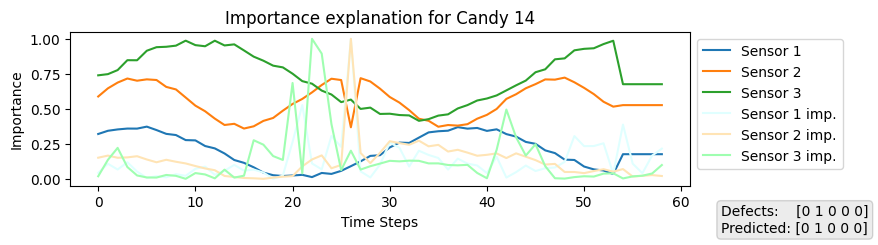

In [121]:
import tensorflow as tf 

def normalize(arr, t_min=0, t_max=1):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)    
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

for i in range(len(X_test[:15])):
    if any(y_test[i]):
        input_sample = tf.convert_to_tensor(X_test[i:i + 1], dtype=tf.float32)

        # Use GradientTape to compute the gradient of the output with respect to the input
        with tf.GradientTape() as tape:
            tape.watch(input_sample)
            prediction = model(input_sample)

        # Compute the gradient
        gradient = tape.gradient(prediction, input_sample)
        # Compute the importance (absolute gradient)
        # importance = tf.reduce_sum(tf.abs(gradient), axis=-1).numpy()[0]  # Sum across features


        # Compute absolute gradients without summing
        absolute_gradient = tf.abs(gradient).numpy()  # Convert to NumPy if needed

        # Extract importance for each series (assuming the last dimension represents the series)
        # absolute_gradient.shape = (batch_size, time_steps, num_series)
        importance_per_series = absolute_gradient[0]  # First sample in the batch

        # For each series separately
        series_1_importance = normalize(importance_per_series[:, 0])  # Importance for series 1
        series_2_importance = normalize(importance_per_series[:, 1])  # Importance for series 2
        series_3_importance = normalize(importance_per_series[:, 2])  # Importance for series 3

        
        # normalized_importance = normalize(importance)
        
        binary_pred = tf.cast(prediction > 0.5, dtype=tf.int32)[0]
        # Plot the importance
        # print(f"Defects: {y_test[i]}, Predicted: {binary_pred}")
        plt.figure(figsize=(8, 2))
        for j in range(X_test.shape[2]):  
                plt.plot(X_test[i, :, j], label=f"Sensor {j+1}")
        plt.plot(series_1_importance, label="Sensor 1 imp.", color="lightcyan")
        plt.plot(series_2_importance, label="Sensor 2 imp.", color="moccasin")
        plt.plot(series_3_importance, label="Sensor 3 imp.", color="xkcd:mint")
        plt.title(f"Importance explanation for Candy {i}")
        plt.xlabel("Time Steps")
        plt.ylabel("Importance")
        #labels on right
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
        plt.text(1.05, -0.3, f"Defects:    {y_test[i]}\nPredicted: {binary_pred}", fontsize = 10, bbox=props, transform=plt.gca().transAxes)
        plt.show()


#### Conclusion: Not good enough method, model doesn't seem to have weights that explain predictions precisely. We can see that for example in candy 14 we have orange peak contributed to sensor orange, but we also see a lot of green sensor gradient, even though there is nothing happening on this sensor.

***
# 4.  time steps to observe models performance- BEST

Thanks to maksing time steps, we can see how prediction changes. That lets us understand time step importance for detecting anomalies. This method doesn't match the anomalies with importance. It rather treats all 3 series and anomalies at once. It is based on the initial prediction model and its weights.

In [ ]:
for i in range(len(X_test[:9])):
    # Mask time steps one by one and observe the change in prediction
    baseline_prediction = model.predict(X_test[i:i + 1])
    binarized_predictions = (baseline_prediction > 0.5)[0].astype(int)
    importance = []

    for t in range(X_test.shape[1]):  # Loop over time steps
        masked_sample = X_test[i:i + 1].copy()
        masked_sample[0, t:t+2, :] = 0  # Mask the t-th time step
        new_prediction = model.predict(masked_sample, verbose=0)
        importance.append(np.abs(new_prediction - baseline_prediction).sum())

    # Plot it
    plt.figure(figsize=(8, 2))
    for j in range(X_test.shape[2]):  
        plt.plot(X_test[i, :, j], label=f"Sensor {j+1}")
    plt.plot(importance, label="Importance")
    #Anotate
    plt.title(f"Importance of Time Steps in Candy {i}")
    plt.xlabel("Time Steps")
    plt.ylabel("Change in Prediction")
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
    plt.text(1.05, 0.0, f"Defects:    {y_test[i]}\nPredicted: {binarized_predictions}", fontsize = 10, bbox=props, transform=plt.gca().transAxes)
    plt.show() 


#### The red line is importance- how important is particulat time step to the predictions. Based on this we can see in which part of the candy production there is a problem.
### Candy 0-wrongly classified 
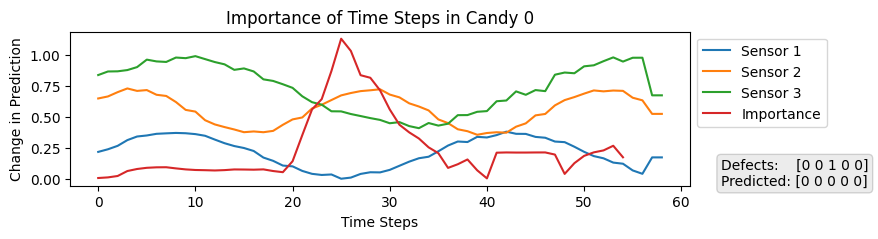

due to 20-30 time step. Can't really say why, hard to understand what inclined network to predict anomaly.
### Candy 1- no anomalies.
### Candy 2 
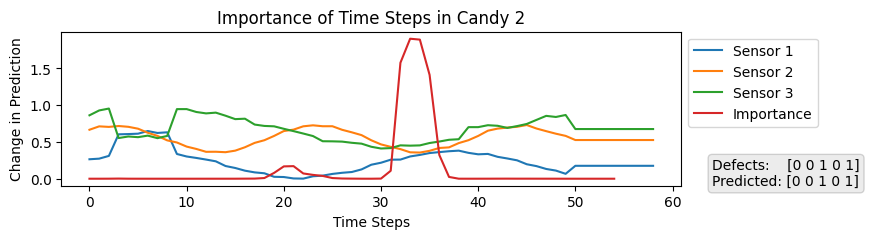

The last anomaly- green-blue tradeoff is evidently not flagged by importance. After 30th time step importance is peaking, even though i think there is no anomaly there. I think the anomaly we're looking for is around 40-50th time step. In this case, we see that the explainability isn't performing well.
### Candy 3 
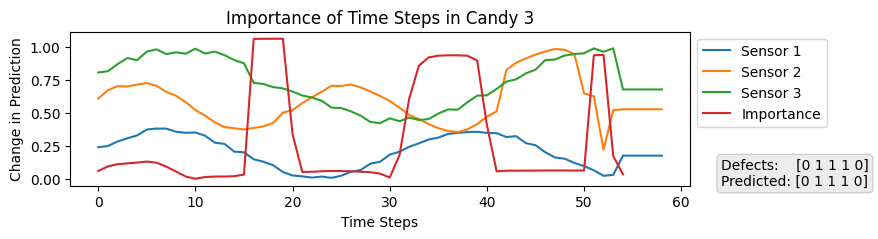

I think 2/3 of the predictions are well labeled with importance. I believe 1st and 3rd peaks in importance are the defects. It obviously doesn't detect well the anomaly with orange sensor for 8 time steps. This is to be expected, as we mask 2 time steps. If we were to mask more time steps, we probably would discover the anomalies that take more than 2 time steps better.
### Candy 4- no anomalies.
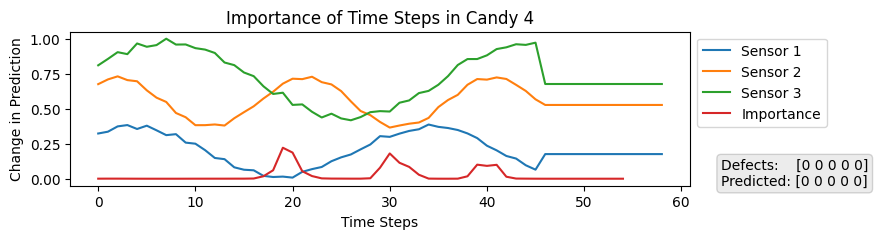

### Candy 5
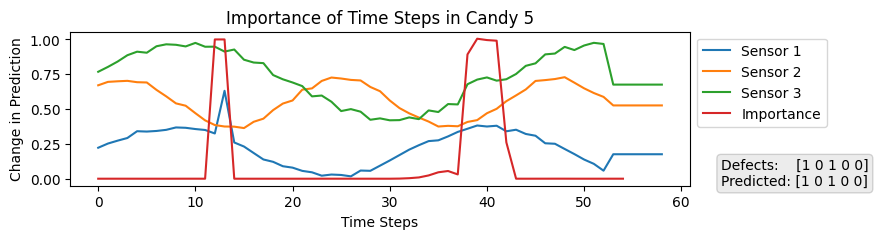

We can see blue peak around 12 time step, well classified. For 38th time step there is probably the green 4 steps long anomaly, that is even hard to see, but model predicts it well, and importance suggests that this is it. Importance works well on this example.
### Candy 6
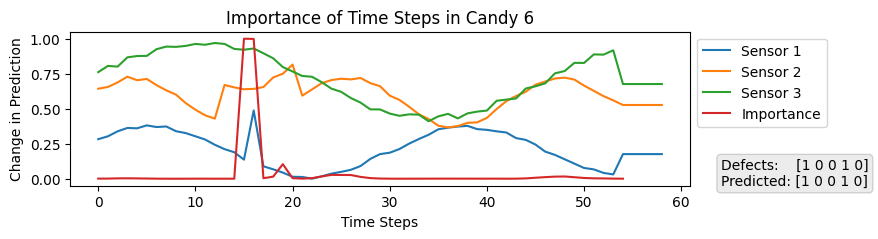

We have well predicted and marked blue peak. The orange 8 time steps long anomalie isnt marked, but that is probably because we mask 2 time steps at a time. If we marked more than 2, we probably would see it maked too.
### Candy 7
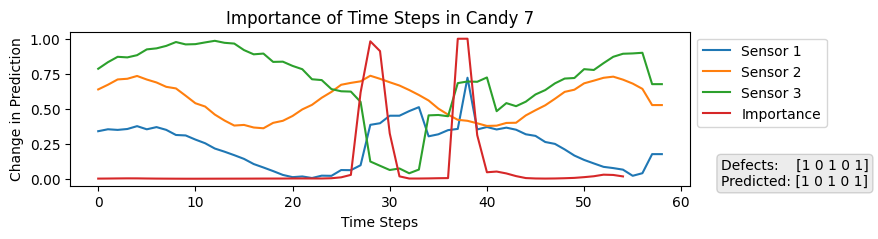

We can see blue peak marked well, the blue-green tradeoff is also marked, not entirely, but always something. Hard to say what about green 4 long, as it around the same time steps as blue peak. It is possible that importnace around 38th marks for 2 anomalies at once.
### Candy 8
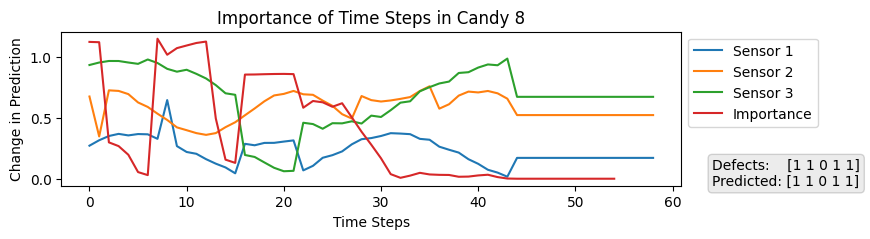

We see well marked orange dip anomaly, blue-green tradeoff entirely marked, blue peak marked with excess and not marked orange anomalie of length 8. As said earlier, its due to masking 2 time steps at once only.

### Conclusions: 
orange long anomaly isn't marked, as it would require to mask more than 2 steps at once, and it is not performed. Peaks in orange and blue are well marked. There are inambiguities when it comes to anomalies that are in the same time steps, as this method doesn't match particular anomaly with importance. It treats whole 3 series prediction at once.
****
  

# 5 Masking of time steps with importance for each label - BEST 2.0
This is the same idea as before, but we show importance for each label separately

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(len(X_test[:10])):
    baseline_prediction = model.predict(X_test[i:i + 1])[0]  # Shape: (5,)
    importance = np.zeros((X_test.shape[1], baseline_prediction.shape[0]))  # Shape: (time_steps, num_labels)

    for t in range(X_test.shape[1]):  # Loop over time steps
        masked_sample = X_test[i:i + 1].copy()
        masked_sample[0, t:t+2, :] = 0  # Mask the t-th time step
        new_prediction = model.predict(masked_sample, verbose=0)[0]
        importance[t] = np.abs(new_prediction - baseline_prediction)  # Compute per-label differences

    # Plot the importance for each label
    plt.figure(figsize=(8,5))
    color = ["cyan", "gold", "lime", "red", "dimgray"]
    defects = ["Blue out.", "Orange dip", "Green 4 long", "Orange len8", "Blue-Green"]
    for j in range(X_test.shape[2]):  
            plt.plot(X_test[i, :, j], label=f"Sensor {j+1}")
    for label_idx in range(importance.shape[1]):
        plt.plot(importance[:, label_idx], label=defects[label_idx], color=color[label_idx])
    plt.title(f"Per-Label Importance of Time Steps for Candy {i}")
    plt.xlabel("Time Steps")
    plt.ylabel("Change in Prediction (Per Label)")
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
    plt.text(1.05, 0.3, f"Defects:    {y_test[i]}\nPredicted: {(baseline_prediction > 0.5).astype(int)}", fontsize = 10, bbox=props, transform=plt.gca().transAxes)    
    plt.show()


#### Each line in color simillar to the sensor is a anomaly related to it. 
### Candy 0
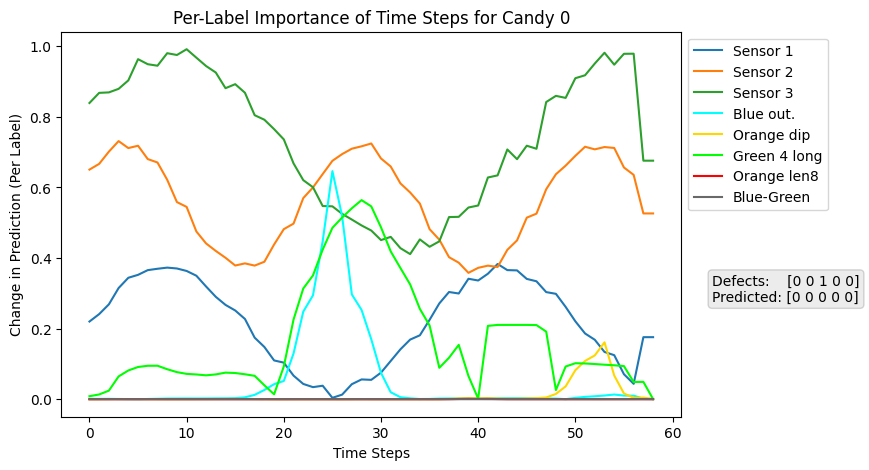

Hard to say what is the anomaly from human perspective, but looking at the explainability its the 42th step in green sensor. It is possible, and with this example we see that model helps with the explainability.
### Candy 1- no anomalies.
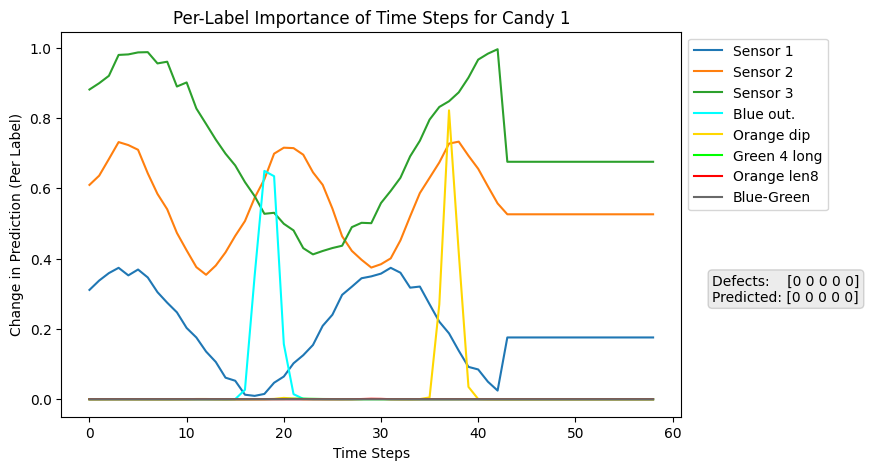
### Candy 2 
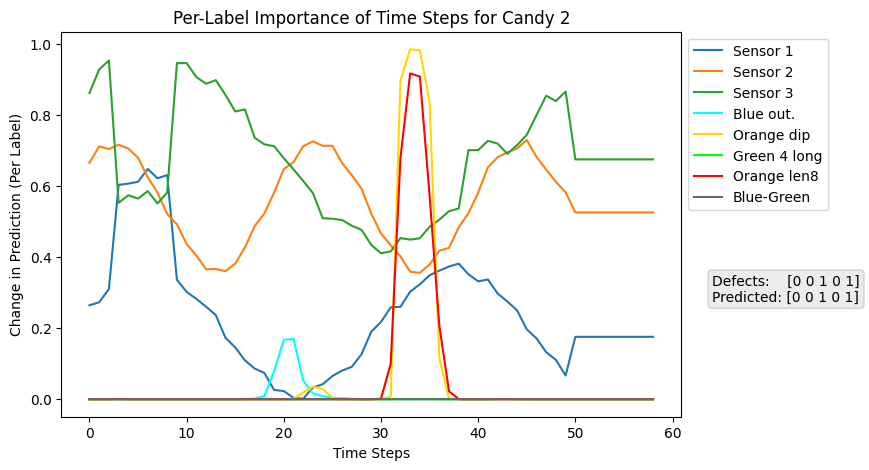

Here explainability isnt performing well. We can see that there supposedly are problems on orange sensor at 30+th step, but there are none. Green and green-blue tradeoff aren't explained.
### Candy 3 
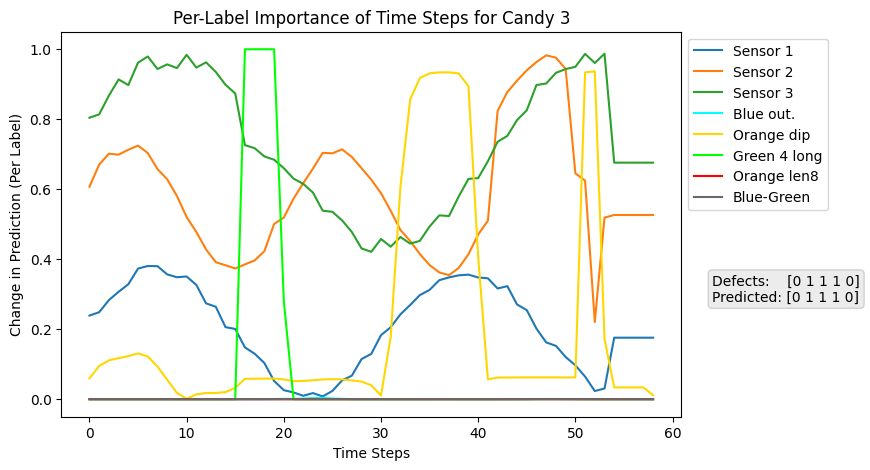

I believe green 4 long anomaly is marked well, as is orange dip at 50th time step. Orange long anomaly isn't detected well, because of the 2 time step masking (should be longer to work)
### Candy 4- no anomalies.

### Candy 5
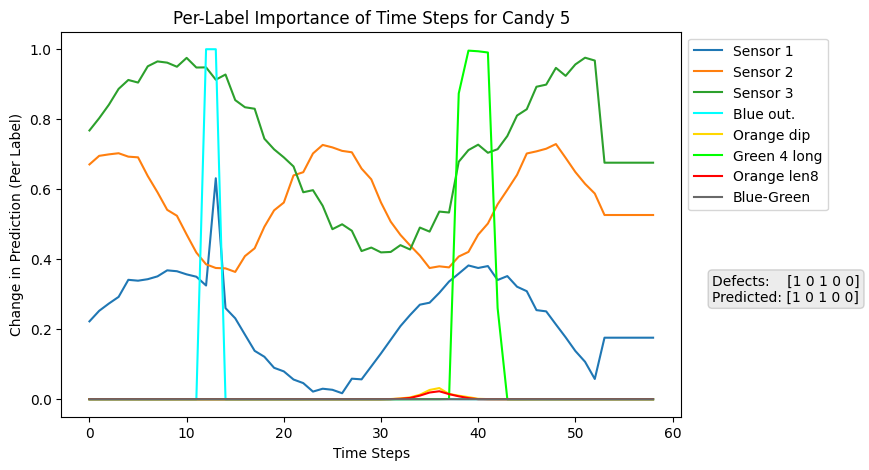

Both anomalies well explained. 
### Candy 6
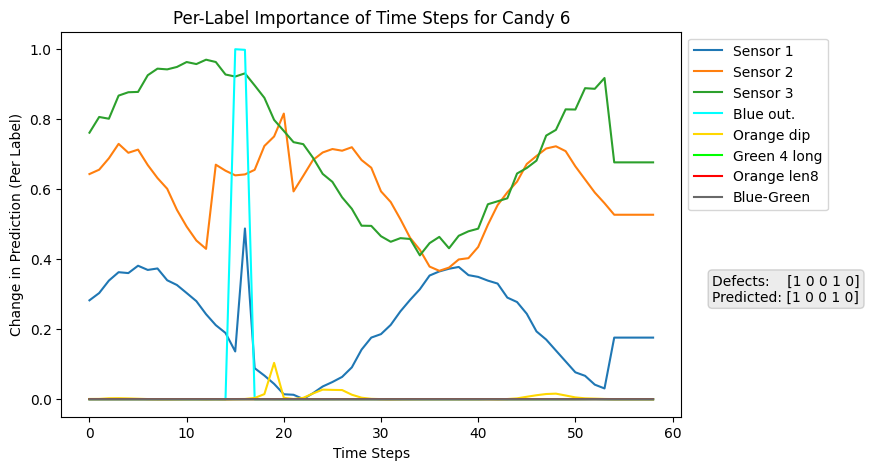

We have well predicted and marked blue peak. The orange 8 time steps long anomalie isnt marked, but that is probably because we mask 2 time steps at a time. If we marked more than 2, we probably would see it maked too.
### Candy 7
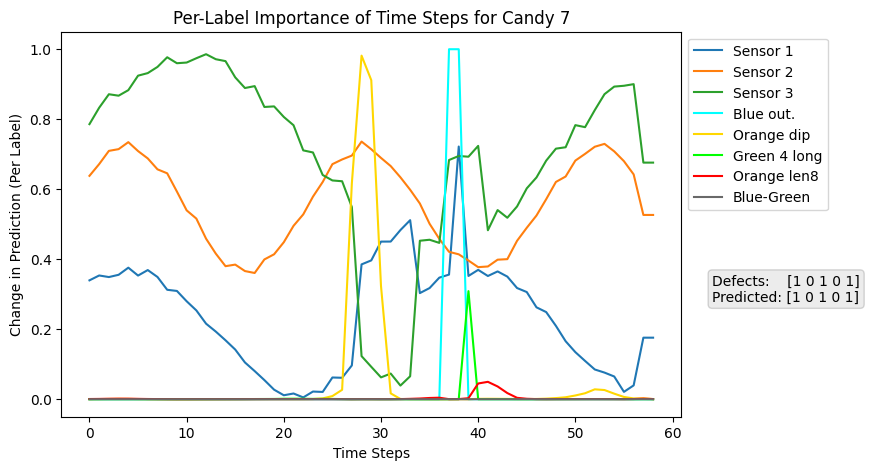

We can see blue peak marked well. Blue-green tradeoff isn't marked. Green 4 long anomaly seems to be a bit marked. 
### Candy 8
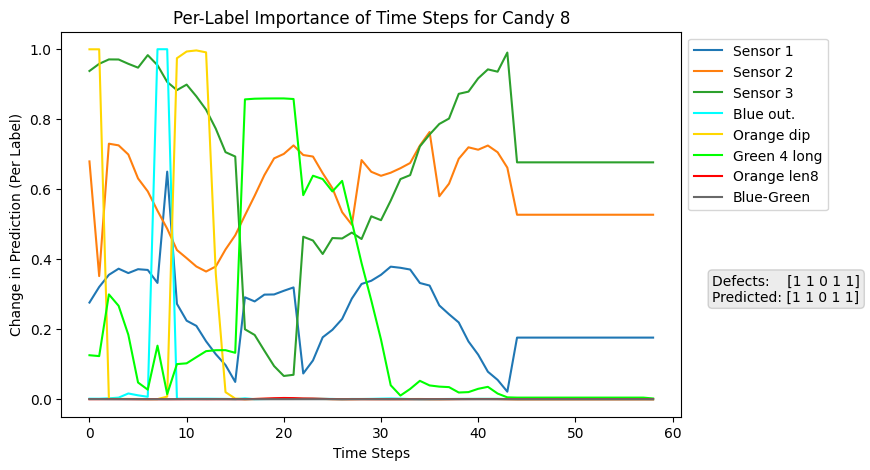

Blue is marked. Tradeoff seems to be marked as green anomaly. Orange dip marked, but we see false positive for orange at around 10th step. 


### Conclusions: 
The decpmposition of importance to particular labels seems to work well, but not for trade-off, as its always marked as some other label importance. Long orange anomaly is still the same problem. Needs masking for more than 2 time steps.
****
  

# At the end, the best method for explainability of importance of time steps to the predictions is masking particular time steps and comparison of predictions. 
### No gradient method seemed to work
### No attention method seemed to work
